In [1]:
import os
from main import *
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
import missingno as msno

# Importe as bibliotecas necessárias
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

sns.set_style('whitegrid')

# Aeroportos analisados

A partir dos 12 aeroportos fornecidos, foram adquiradas as coordenadas de cada um deles para o calculo da distancia

# BIMTRA

## Import do dataset pela API

In [2]:
# Pega o df do BIMTRA da API
df_bimtra_raw = request_api(endpoint='bimtra', inicial_date = '2022-06-01', final_date ='2023-05-13')

In [3]:
df_bimtra_raw['deltaT'] = df_bimtra_raw['dt_arr']-df_bimtra_raw['dt_dep']

df_bimtra_raw[['dt_dep','dt_arr']] = df_bimtra_raw[['dt_dep','dt_arr']]/1000

df_bimtra_raw['dt_dep'] = pd.to_datetime(df_bimtra_raw['dt_dep'], unit ='s')

df_bimtra_raw['hora_ref'] = df_bimtra_raw['dt_dep'].dt.floor('H')

df_bimtra_raw['hora_esperas'] = df_bimtra_raw['hora_ref'] - pd.to_timedelta('1 hour')

df_bimtra_raw['hora_metaf'] = df_bimtra_raw['hora_ref'] + pd.to_timedelta('1 hour')

df_bimtra_raw['hora_metar']  = df_bimtra_raw['hora_ref']

df_bimtra_raw['hora_tcp'] = df_bimtra_raw['hora_ref'] + pd.to_timedelta('1 hour')

df_bimtra_raw

,flightid,origem,destino,dt_dep,dt_arr,deltaT,hora_ref,hora_esperas,hora_metaf,hora_metar,hora_tcp
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,2022-06-01 00:44:57,1.654047e+09,2463000,2022-06-01 00:00:00,2022-05-31 23:00:00,2022-06-01 01:00:00,2022-06-01 00:00:00,2022-06-01 01:00:00
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,2022-06-01 00:57:01,1.654047e+09,2152000,2022-06-01 00:00:00,2022-05-31 23:00:00,2022-06-01 01:00:00,2022-06-01 00:00:00,2022-06-01 01:00:00
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,2022-06-01 00:26:52,1.654048e+09,4613000,2022-06-01 00:00:00,2022-05-31 23:00:00,2022-06-01 01:00:00,2022-06-01 00:00:00,2022-06-01 01:00:00
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,2022-06-01 00:58:40,1.654048e+09,2581000,2022-06-01 00:00:00,2022-05-31 23:00:00,2022-06-01 01:00:00,2022-06-01 00:00:00,2022-06-01 01:00:00
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,1.654051e+09,5547000,2022-06-01 01:00:00,2022-06-01 00:00:00,2022-06-01 02:00:00,2022-06-01 01:00:00,2022-06-01 02:00:00
...,...,...,...,...,...,...,...,...,...,...,...
300342,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,2023-05-13 12:14:19,1.683988e+09,7564000,2023-05-13 12:00:00,2023-05-13 11:00:00,2023-05-13 13:00:00,2023-05-13 12:00:00,2023-05-13 13:00:00
300343,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,2023-05-13 09:33:15,1.683976e+09,5126000,2023-05-13 09:00:00,2023-05-13 08:00:00,2023-05-13 10:00:00,2023-05-13 09:00:00,2023-05-13 10:00:00
300344,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,2023-05-13 16:53:53,1.684004e+09,7591000,2023-05-13 16:00:00,2023-05-13 15:00:00,2023-05-13 17:00:00,2023-05-13 16:00:00,2023-05-13 17:00:00
300345,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,2023-05-13 05:28:58,1.683964e+09,8743000,2023-05-13 05:00:00,2023-05-13 04:00:00,2023-05-13 06:00:00,2023-05-13 05:00:00,2023-05-13 06:00:00


# CAT-62


In [6]:
# Pega o df do BIMTRA da API
df_cat62 = request_api(endpoint='cat-62', inicial_date ='2022-12-01 00:00:00.000', final_date ='2022-12-02 00:00:00.000')

df_cat62


,flightid,lat,lon,flightlevel,speed,dt_radar
0,5385ee71712e2767734b1a22ba578608,-0.455105,-0.857866,170.0,254.0,1669866124000
1,5385ee71712e2767734b1a22ba578608,-0.514713,-0.889700,130.0,196.0,1669862641000
2,5385ee71712e2767734b1a22ba578608,-0.501200,-0.884548,200.0,214.0,1669863483000
3,5385ee71712e2767734b1a22ba578608,-0.409147,-0.811933,33.0,107.0,1669869306000
4,5385ee71712e2767734b1a22ba578608,-0.504845,-0.886623,184.0,216.0,1669863246000
...,...,...,...,...,...,...
123592,707d489f28dad61fd05a083a45d835b0,-0.411834,-0.782337,300.0,376.0,1669887786000
123593,707d489f28dad61fd05a083a45d835b0,-0.404333,-0.763283,282.0,455.0,1669887183000
123594,707d489f28dad61fd05a083a45d835b0,-0.416969,-0.800194,160.0,301.0,1669888381000
123595,707d489f28dad61fd05a083a45d835b0,-0.420147,-0.804702,126.0,263.0,1669888621000


# ESPERAS

## Duvidas

Esperas? Que diabos é isso?

In [7]:
# Pega o df do ESPERAS DE VOOS da API
df_esperas = request_api(endpoint='esperas', inicial_date = '2022-06-01', final_date ='2023-05-13')

df_esperas[df_esperas['esperas']!=0]

,esperas,hora,aero
548,1,1656014400000,SBBR
902,1,1657288800000,SBBR
1237,3,1658494800000,SBBR
1305,1,1658739600000,SBBR
1323,1,1658804400000,SBBR
...,...,...,...
99423,2,1682175600000,SBSV
99447,1,1682262000000,SBSV
99495,1,1682434800000,SBSV
99880,3,1683820800000,SBSV


In [8]:
df_esperas['hora'] = df_esperas['hora']/1000

df_esperas['hora'] = pd.to_datetime(df_esperas['hora'], unit ='s')


df_esperas

,esperas,hora,aero
0,0,2022-06-01 00:00:00,SBBR
1,0,2022-06-01 01:00:00,SBBR
2,0,2022-06-01 02:00:00,SBBR
3,0,2022-06-01 03:00:00,SBBR
4,0,2022-06-01 04:00:00,SBBR
...,...,...,...
99931,0,2023-05-13 19:00:00,SBSV
99932,0,2023-05-13 20:00:00,SBSV
99933,0,2023-05-13 21:00:00,SBSV
99934,0,2023-05-13 22:00:00,SBSV


# METAF

## Separar em colunas os dados

In [9]:
# Pega o df do ESPERAS DE VOOS da API
df_metaf = request_api(endpoint='metaf',inicial_date = '2022-06-01', final_date ='2023-05-13')

df_metaf

,hora,metaf,aero
0,1659657600000,METAF SBBR 050000Z 05006KT CAVOK 18/04 Q1014=\n,SBBR
1,1659661200000,METAF SBBR 050100Z 01006KT CAVOK 17/05 Q1016=\n,SBBR
2,1659664800000,METAF SBBR 050200Z 35008KT CAVOK 17/05 Q1014=\n,SBBR
3,1659668400000,METAF SBBR 050300Z 34007KT CAVOK 16/05 Q1015=\n,SBBR
4,1659672000000,METAF SBBR 050400Z 34008KT CAVOK 16/05 Q1015=\n,SBBR
...,...,...,...
43933,1684004400000,METAF SBSP 131900Z 14010KT 9999 OVC024 ...,SBSP
43934,1684008000000,METAF SBSP 132000Z 14009KT 9999 BKN033 ...,SBSP
43935,1684011600000,METAF SBSP 132100Z 14008KT 8000 OVC033 ...,SBSP
43936,1684015200000,METAF SBSP 132200Z 14007KT 7000 OVC033 ...,SBSP


In [10]:
df_metaf['hora'] = df_metaf['hora']/1000

df_metaf['hora'] = pd.to_datetime(df_metaf['hora'], unit ='s')

df_metaf

,hora,metaf,aero
0,2022-08-05 00:00:00,METAF SBBR 050000Z 05006KT CAVOK 18/04 Q1014=\n,SBBR
1,2022-08-05 01:00:00,METAF SBBR 050100Z 01006KT CAVOK 17/05 Q1016=\n,SBBR
2,2022-08-05 02:00:00,METAF SBBR 050200Z 35008KT CAVOK 17/05 Q1014=\n,SBBR
3,2022-08-05 03:00:00,METAF SBBR 050300Z 34007KT CAVOK 16/05 Q1015=\n,SBBR
4,2022-08-05 04:00:00,METAF SBBR 050400Z 34008KT CAVOK 16/05 Q1015=\n,SBBR
...,...,...,...
43933,2023-05-13 19:00:00,METAF SBSP 131900Z 14010KT 9999 OVC024 ...,SBSP
43934,2023-05-13 20:00:00,METAF SBSP 132000Z 14009KT 9999 BKN033 ...,SBSP
43935,2023-05-13 21:00:00,METAF SBSP 132100Z 14008KT 8000 OVC033 ...,SBSP
43936,2023-05-13 22:00:00,METAF SBSP 132200Z 14007KT 7000 OVC033 ...,SBSP


# METAR

In [11]:
# Pega o df do ESPERAS DE VOOS da API
df_metar = request_api(endpoint='metar', inicial_date = '2022-06-01', final_date ='2023-05-13')

df_metar

,hora,metar,aero
0,1654041600000,METAR SBBR 010000Z 07002KT CAVOK 21/08 Q1018=,SBBR
1,1654045200000,METAR SBBR 010100Z 10002KT CAVOK 20/09 Q1019=,SBBR
2,1654048800000,METAR SBBR 010200Z 00000KT CAVOK 16/09 Q1019=,SBBR
3,1654052400000,METAR SBBR 010300Z 27002KT CAVOK 16/09 Q1019=,SBBR
4,1654056000000,METAR SBBR 010400Z 00000KT CAVOK 14/09 Q1018=,SBBR
...,...,...,...
106739,1684004400000,METAR SBSV 131900Z 16009KT 9999 BKN020 FEW021T...,SBSV
106740,1684008000000,METAR SBSV 132000Z 13007KT 9999 BKN020 29/24 Q...,SBSV
106741,1684011600000,METAR SBSV 132100Z 12005KT 9999 SCT020 FEW025T...,SBSV
106742,1684015200000,METAR SBSV 132200Z 11006KT 9999 SCT020 FEW025T...,SBSV


In [12]:
df_metar['hora'] = df_metar['hora']/1000

df_metar['hora'] = pd.to_datetime(df_metar['hora'], unit ='s')

df_metar

,hora,metar,aero
0,2022-06-01 00:00:00,METAR SBBR 010000Z 07002KT CAVOK 21/08 Q1018=,SBBR
1,2022-06-01 01:00:00,METAR SBBR 010100Z 10002KT CAVOK 20/09 Q1019=,SBBR
2,2022-06-01 02:00:00,METAR SBBR 010200Z 00000KT CAVOK 16/09 Q1019=,SBBR
3,2022-06-01 03:00:00,METAR SBBR 010300Z 27002KT CAVOK 16/09 Q1019=,SBBR
4,2022-06-01 04:00:00,METAR SBBR 010400Z 00000KT CAVOK 14/09 Q1018=,SBBR
...,...,...,...
106739,2023-05-13 19:00:00,METAR SBSV 131900Z 16009KT 9999 BKN020 FEW021T...,SBSV
106740,2023-05-13 20:00:00,METAR SBSV 132000Z 13007KT 9999 BKN020 29/24 Q...,SBSV
106741,2023-05-13 21:00:00,METAR SBSV 132100Z 12005KT 9999 SCT020 FEW025T...,SBSV
106742,2023-05-13 22:00:00,METAR SBSV 132200Z 11006KT 9999 SCT020 FEW025T...,SBSV


# SATELITE

In [61]:
# Pega o df do ESPERAS DE VOOS da API
df_satelite = request_api(endpoint='satelite', inicial_date = '2022-06-01', final_date ='2023-05-13')

df_satelite

,data,path,tamanho
0,2022-06-01 01:00:00,http://satelite.cptec.inpe.br/repositoriogoes/...,1879673
1,2022-06-01 02:00:00,http://satelite.cptec.inpe.br/repositoriogoes/...,1877693
2,2022-06-01 03:00:00,http://satelite.cptec.inpe.br/repositoriogoes/...,1887299
3,2022-06-01 04:00:00,http://satelite.cptec.inpe.br/repositoriogoes/...,1890950
4,2022-06-01 05:00:00,http://satelite.cptec.inpe.br/repositoriogoes/...,1892776
...,...,...,...
8282,2023-05-13 19:00:00,http://satelite.cptec.inpe.br/repositoriogoes/...,1830030
8283,2023-05-13 20:00:00,http://satelite.cptec.inpe.br/repositoriogoes/...,1828890
8284,2023-05-13 21:00:00,http://satelite.cptec.inpe.br/repositoriogoes/...,1823160
8285,2023-05-13 22:00:00,http://satelite.cptec.inpe.br/repositoriogoes/...,1809551


# TC Prev


In [13]:
# Pega o df do ESPERAS DE VOOS da API
df_tcprev = request_api(endpoint='tc-prev', inicial_date = '2022-06-01', final_date ='2023-05-13')

df_tcprev

,hora,troca,aero
0,1654041600000,0,BR
1,1654045200000,0,BR
2,1654048800000,0,BR
3,1654052400000,0,BR
4,1654056000000,0,BR
...,...,...,...
99931,1684004400000,0,SV
99932,1684008000000,0,SV
99933,1684011600000,0,SV
99934,1684015200000,0,SV


In [14]:
df_tcprev['hora'] = df_tcprev['hora']/1000

df_tcprev['hora'] = pd.to_datetime(df_tcprev['hora'], unit ='s')

df_tcprev['aero'] = 'SB' + df_tcprev['aero']

df_tcprev[df_tcprev['troca']!=0]

,hora,troca,aero
15,2022-06-01 15:00:00,1,SBBR
16,2022-06-01 16:00:00,1,SBBR
17,2022-06-01 17:00:00,1,SBBR
18,2022-06-01 18:00:00,1,SBBR
19,2022-06-01 19:00:00,1,SBBR
...,...,...,...
99909,2023-05-12 21:00:00,1,SBSV
99910,2023-05-12 22:00:00,1,SBSV
99911,2023-05-12 23:00:00,1,SBSV
99912,2023-05-13 00:00:00,1,SBSV


# TC Real

In [19]:
# Pega o df do ESPERAS DE VOOS da API
df_tcreal = request_api(endpoint='tc-real', inicial_date = '2022-06-01', final_date ='2023-05-13')

df_tcreal

,hora,nova_cabeceira,antiga_cabeceira,aero
0,1654092843000,32,03,FL
1,1654109470000,18,12,RF
2,1654110745000,16,13,CF
3,1654110758000,15,26,GL
4,1654110777000,15,26,GL
...,...,...,...,...
33426,1683991948000,14,08,FL
33427,1684015596000,17R,12,SP
33428,1683992504000,15,26,CT
33429,1684017668000,17R,12,SP


# Merge dos dados

In [2]:
# Pega o df do BIMTRA da API
df_bimtra_raw.head(5)

NameError: name 'df_bimtra_raw' is not defined

In [16]:
data_raw = df_bimtra_raw.copy()

data_raw = data_raw.merge(df_esperas, left_on=['hora_esperas','destino'], right_on=['hora','aero'], how='left', suffixes=('', '_esperas'))

data_raw = data_raw.merge(df_metaf[['hora','metaf','aero']], left_on=['hora_metaf','destino'], right_on=['hora','aero'], how='left', suffixes=('', '_metaf'))

data_raw = data_raw.merge(df_metar[['hora','metar','aero']], left_on=['hora_metar','destino'], right_on=['hora','aero'], how='left', suffixes=('', '_metar'))

data_raw = data_raw.merge(df_tcprev[['hora','troca','aero']], left_on=['hora_tcp','destino'], right_on=['hora','aero'], how='left', suffixes=('', '_tcp'))

data_raw = data_raw.set_index('flightid')

data_raw.head()

,origem,destino,dt_dep,dt_arr,deltaT,hora_ref,hora_esperas,hora_metaf,hora_metar,hora_tcp,...,aero,hora_metaf,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp
flightid,,,,,,,,,,,,,,,,,,,,,
fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,2022-06-01 00:44:57,1.654047e+09,2463000,2022-06-01 00:00:00,2022-05-31 23:00:00,2022-06-01 01:00:00,2022-06-01 00:00:00,2022-06-01 01:00:00,...,NaN,NaT,NaN,NaN,2022-06-01 00:00:00,METAR SBRJ 010000Z 17006KT 9999 SCT025 OVC050 ...,SBRJ,2022-06-01 01:00:00,0.0,SBRJ
c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,2022-06-01 00:57:01,1.654047e+09,2152000,2022-06-01 00:00:00,2022-05-31 23:00:00,2022-06-01 01:00:00,2022-06-01 00:00:00,2022-06-01 01:00:00,...,NaN,NaT,NaN,NaN,2022-06-01 00:00:00,METAR SBRJ 010000Z 17006KT 9999 SCT025 OVC050 ...,SBRJ,2022-06-01 01:00:00,0.0,SBRJ
3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,2022-06-01 00:26:52,1.654048e+09,4613000,2022-06-01 00:00:00,2022-05-31 23:00:00,2022-06-01 01:00:00,2022-06-01 00:00:00,2022-06-01 01:00:00,...,NaN,NaT,NaN,NaN,2022-06-01 00:00:00,METAR SBRJ 010000Z 17006KT 9999 SCT025 OVC050 ...,SBRJ,2022-06-01 01:00:00,0.0,SBRJ
8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,2022-06-01 00:58:40,1.654048e+09,2581000,2022-06-01 00:00:00,2022-05-31 23:00:00,2022-06-01 01:00:00,2022-06-01 00:00:00,2022-06-01 01:00:00,...,NaN,NaT,NaN,NaN,2022-06-01 00:00:00,METAR SBCF 010000Z 12006KT CAVOK 21/14 Q1018=,SBCF,2022-06-01 01:00:00,0.0,SBCF
504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,1.654051e+09,5547000,2022-06-01 01:00:00,2022-06-01 00:00:00,2022-06-01 02:00:00,2022-06-01 01:00:00,2022-06-01 02:00:00,...,SBFL,NaT,NaN,NaN,2022-06-01 01:00:00,METAR SBFL 010100Z 15005KT 9999 BKN030 13/07 Q...,SBFL,2022-06-01 02:00:00,0.0,SBFL


# Baseline Model

## Drop de Colunas

In [17]:
data = data_raw[data_raw.columns.drop([ 'dt_arr','hora_ref', 'hora_esperas', 'hora_metaf', 'hora_metar', 'hora_tcp','hora', 'aero', 'hora_metaf', 'aero_metaf','hora_metar', 'aero_metar', 'hora_tcp', 'aero_tcp'])].copy()

data['deltaT'] = data['deltaT']/1000

data

,origem,destino,dt_dep,deltaT,esperas,metaf,metar,troca
flightid,,,,,,,,
fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,2022-06-01 00:44:57,2463.0,NaN,NaN,METAR SBRJ 010000Z 17006KT 9999 SCT025 OVC050 ...,0.0
c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,2022-06-01 00:57:01,2152.0,NaN,NaN,METAR SBRJ 010000Z 17006KT 9999 SCT025 OVC050 ...,0.0
3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,2022-06-01 00:26:52,4613.0,NaN,NaN,METAR SBRJ 010000Z 17006KT 9999 SCT025 OVC050 ...,0.0
8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,2022-06-01 00:58:40,2581.0,NaN,NaN,METAR SBCF 010000Z 12006KT CAVOK 21/14 Q1018=,0.0
504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,5547.0,0.0,NaN,METAR SBFL 010100Z 15005KT 9999 BKN030 13/07 Q...,0.0
...,...,...,...,...,...,...,...,...
c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,2023-05-13 12:14:19,7564.0,0.0,NaN,METAR SBRF 131200Z 14006KT 9999 SCT025 29/22 Q...,0.0
e4f5686cce45083566945c8946e5d120,SBBR,SBGR,2023-05-13 09:33:15,5126.0,0.0,METAF SBGR 131000Z 11004KT 1000 BR OVC033...,METAR SBGR 130900Z 11004KT 9999 SCT030 12/11 Q...,0.0
04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,2023-05-13 16:53:53,7591.0,0.0,NaN,METAR SBRF 131600Z 10008KT 9999 SCT025 29/22 Q...,0.0


# Checkagem dos dados faltantes

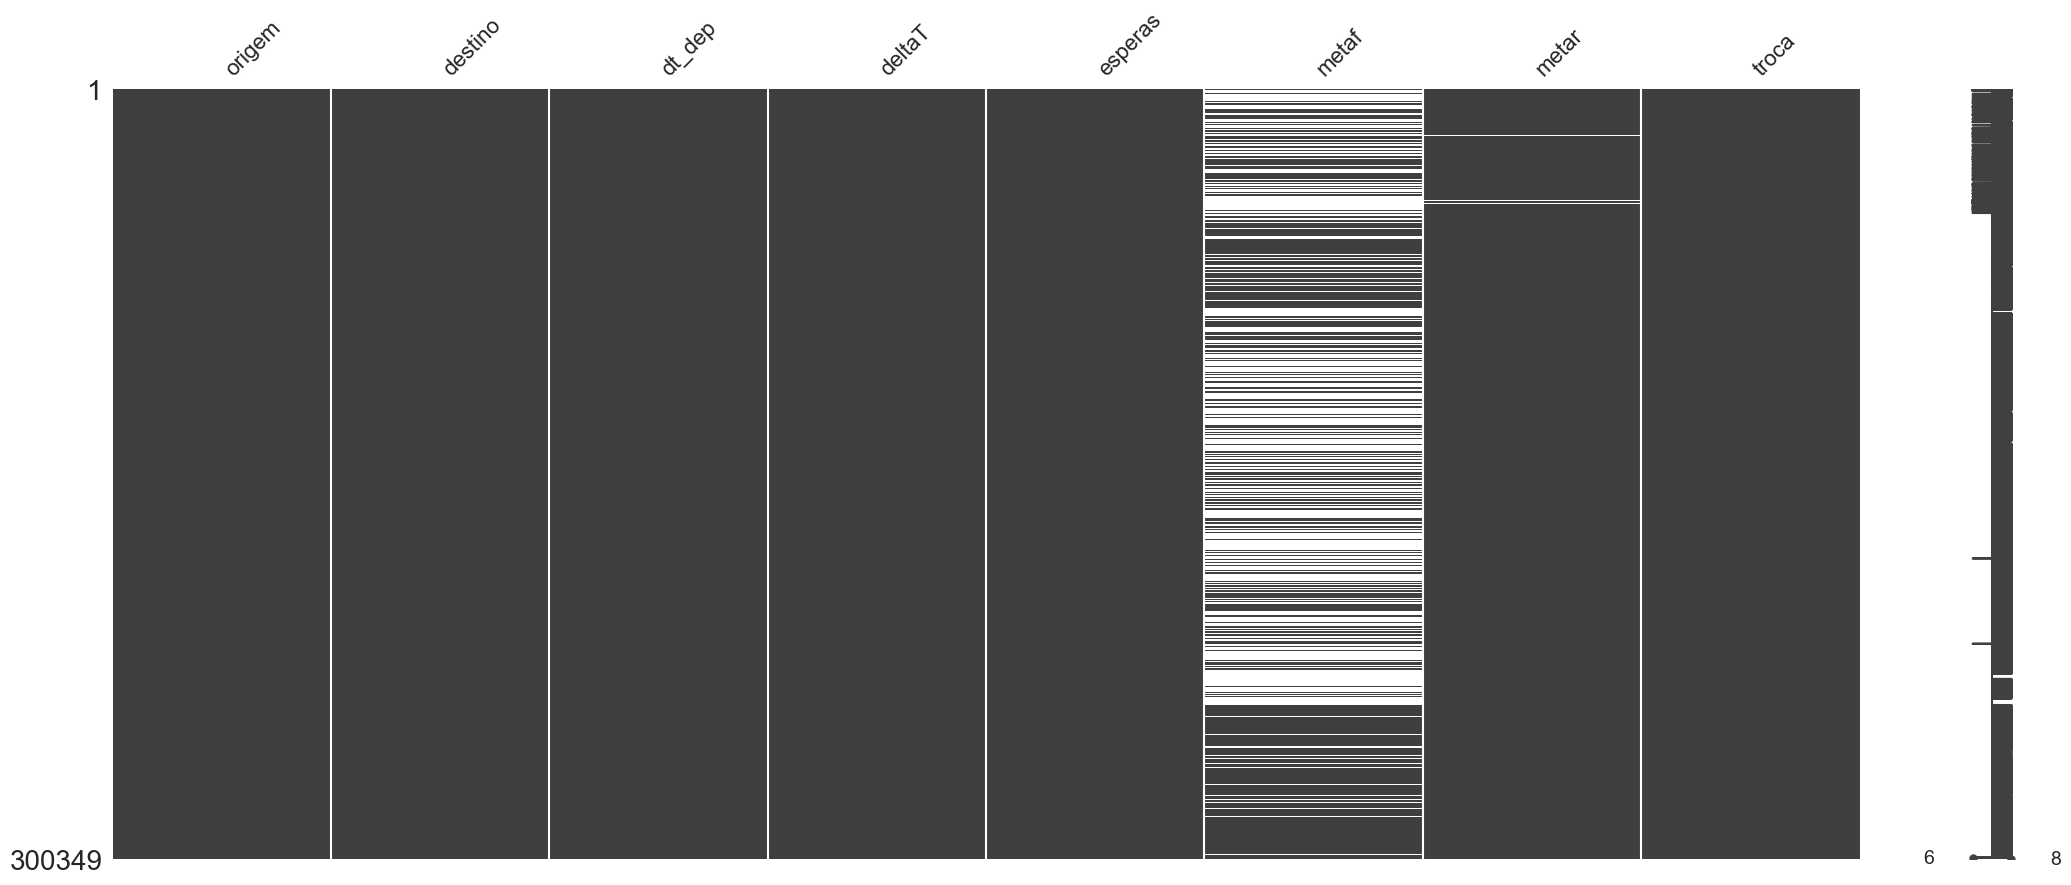

In [18]:
msno.matrix(data)
plt.show()

In [19]:
data = data.dropna(subset=['esperas', 'troca', 'metar'])
data

,origem,destino,dt_dep,deltaT,esperas,metaf,metar,troca
flightid,,,,,,,,
504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,5547.0,0.0,NaN,METAR SBFL 010100Z 15005KT 9999 BKN030 13/07 Q...,0.0
052050016538ab736a254313ef009a6b,SBRJ,SBCF,2022-06-01 09:20:04,3006.0,0.0,NaN,METAR SBCF 010900Z 15002KT CAVOK 17/14 Q1019=,0.0
e93e3b8510854a55f195788019b5763b,SBGR,SBPA,2022-06-01 01:20:45,5020.0,0.0,NaN,METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04...,0.0
2386fcd950814c8d343d93c4b51585d1,SBGR,SBPA,2022-06-01 01:13:59,5262.0,0.0,NaN,METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04...,0.0
f738e67220fcd688fed028a6389891e2,SBKP,SBPA,2022-06-01 01:26:38,5084.0,0.0,NaN,METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04...,0.0
...,...,...,...,...,...,...,...,...
c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,2023-05-13 12:14:19,7564.0,0.0,NaN,METAR SBRF 131200Z 14006KT 9999 SCT025 29/22 Q...,0.0
e4f5686cce45083566945c8946e5d120,SBBR,SBGR,2023-05-13 09:33:15,5126.0,0.0,METAF SBGR 131000Z 11004KT 1000 BR OVC033...,METAR SBGR 130900Z 11004KT 9999 SCT030 12/11 Q...,0.0
04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,2023-05-13 16:53:53,7591.0,0.0,NaN,METAR SBRF 131600Z 10008KT 9999 SCT025 29/22 Q...,0.0


# Tipos dos dados

In [20]:
data[['esperas','troca']] = data[['esperas','troca']].astype('int')

data.dtypes

c:\Users\jorge\anaconda3\envs\IA\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


origem             object
destino            object
dt_dep     datetime64[ns]
deltaT            float64
esperas             int32
metaf              object
metar              object
troca               int32
dtype: object

In [21]:
# Cálculo da distancia entre as coordenadas do aeroporto
data['distance'] = data.apply(calcular_distancia, axis=1)

data

c:\Users\jorge\anaconda3\envs\IA\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,origem,destino,dt_dep,deltaT,esperas,metaf,metar,troca,distance
flightid,,,,,,,,,
504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,5547.0,0,NaN,METAR SBFL 010100Z 15005KT 9999 BKN030 13/07 Q...,0,1007.982120
052050016538ab736a254313ef009a6b,SBRJ,SBCF,2022-06-01 09:20:04,3006.0,0,NaN,METAR SBCF 010900Z 15002KT CAVOK 17/14 Q1019=,0,373.769188
e93e3b8510854a55f195788019b5763b,SBGR,SBPA,2022-06-01 01:20:45,5020.0,0,NaN,METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04...,0,866.126835
2386fcd950814c8d343d93c4b51585d1,SBGR,SBPA,2022-06-01 01:13:59,5262.0,0,NaN,METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04...,0,866.126835
f738e67220fcd688fed028a6389891e2,SBKP,SBPA,2022-06-01 01:26:38,5084.0,0,NaN,METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04...,0,874.428439
...,...,...,...,...,...,...,...,...,...
c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,2023-05-13 12:14:19,7564.0,0,NaN,METAR SBRF 131200Z 14006KT 9999 SCT025 29/22 Q...,0,1654.523543
e4f5686cce45083566945c8946e5d120,SBBR,SBGR,2023-05-13 09:33:15,5126.0,0,METAF SBGR 131000Z 11004KT 1000 BR OVC033...,METAR SBGR 130900Z 11004KT 9999 SCT030 12/11 Q...,0,854.437636
04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,2023-05-13 16:53:53,7591.0,0,NaN,METAR SBRF 131600Z 10008KT 9999 SCT025 29/22 Q...,0,1608.642575


In [22]:
trajetorias = pd.read_csv('trajetorias.csv')
trajetorias.head(5)

,origem,destino,distanceCAT
0,SBBR,SBCF,530.088320
1,SBBR,SBCT,960.846804
2,SBBR,SBFL,1179.012443
3,SBBR,SBGL,835.498310
4,SBBR,SBGR,816.533272


In [23]:
data['flightid'] = data.index
data_merge = data.merge(trajetorias, on=['origem','destino'], how='left')
data_merge.set_index('flightid', inplace=True)
data_merge

c:\Users\jorge\anaconda3\envs\IA\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,origem,destino,dt_dep,deltaT,esperas,metaf,metar,troca,distance,distanceCAT
flightid,,,,,,,,,,
504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,5547.0,0,NaN,METAR SBFL 010100Z 15005KT 9999 BKN030 13/07 Q...,0,1007.982120,910.178961
052050016538ab736a254313ef009a6b,SBRJ,SBCF,2022-06-01 09:20:04,3006.0,0,NaN,METAR SBCF 010900Z 15002KT CAVOK 17/14 Q1019=,0,373.769188,411.540159
e93e3b8510854a55f195788019b5763b,SBGR,SBPA,2022-06-01 01:20:45,5020.0,0,NaN,METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04...,0,866.126835,809.864437
2386fcd950814c8d343d93c4b51585d1,SBGR,SBPA,2022-06-01 01:13:59,5262.0,0,NaN,METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04...,0,866.126835,809.864437
f738e67220fcd688fed028a6389891e2,SBKP,SBPA,2022-06-01 01:26:38,5084.0,0,NaN,METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04...,0,874.428439,794.273105
...,...,...,...,...,...,...,...,...,...,...
c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,2023-05-13 12:14:19,7564.0,0,NaN,METAR SBRF 131200Z 14006KT 9999 SCT025 29/22 Q...,0,1654.523543,1488.045264
e4f5686cce45083566945c8946e5d120,SBBR,SBGR,2023-05-13 09:33:15,5126.0,0,METAF SBGR 131000Z 11004KT 1000 BR OVC033...,METAR SBGR 130900Z 11004KT 9999 SCT030 12/11 Q...,0,854.437636,816.533272
04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,2023-05-13 16:53:53,7591.0,0,NaN,METAR SBRF 131600Z 10008KT 9999 SCT025 29/22 Q...,0,1608.642575,1447.775576


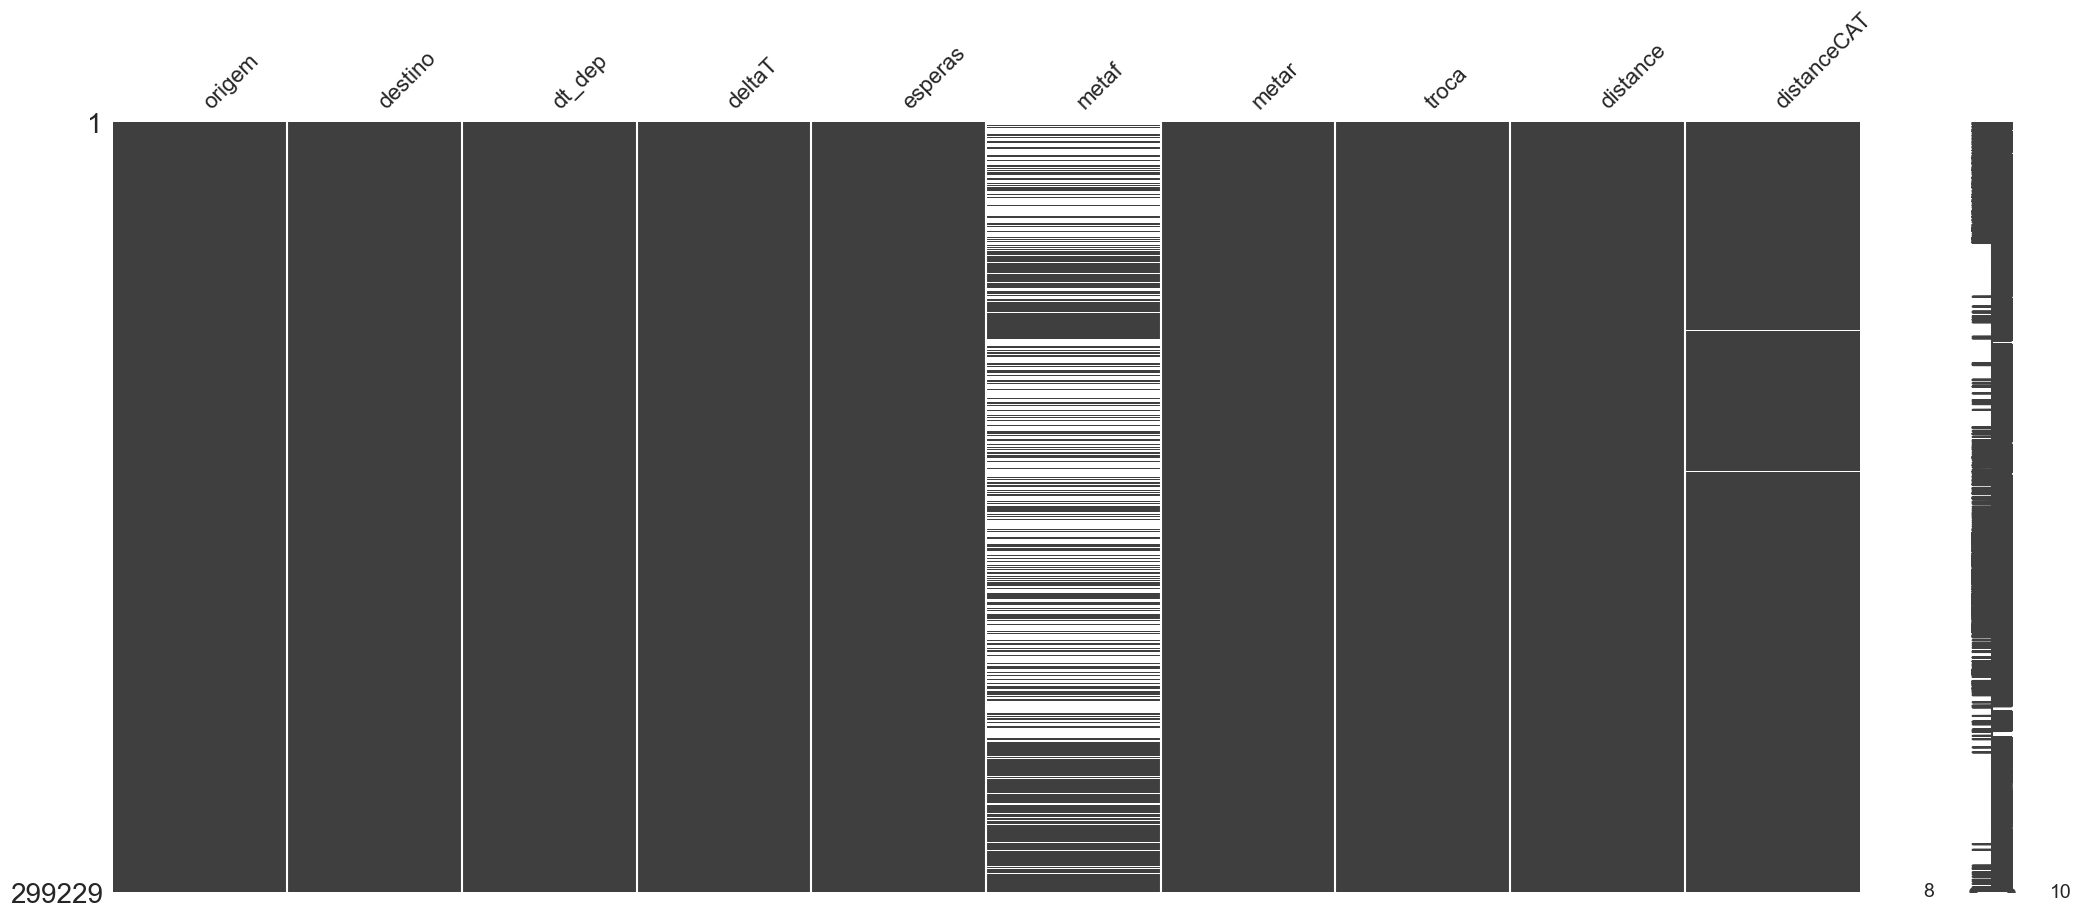

In [24]:
msno.matrix(data_merge)

data_merge['distanceCAT'].fillna(data_merge['distance'], inplace=True)

In [25]:
from sklearn.preprocessing import MinMaxScaler

# Crie um objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajuste e transforme as colunas 'distance' e 'distancecat62'
data_merge[['distance', 'distanceCAT']] = scaler.fit_transform(data_merge[['distance', 'distanceCAT']])

# Exiba o DataFrame com as colunas escaladas
display(data_merge)

,origem,destino,dt_dep,deltaT,esperas,metaf,metar,troca,distance,distanceCAT
flightid,,,,,,,,,,
504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,5547.0,0,NaN,METAR SBFL 010100Z 15005KT 9999 BKN030 13/07 Q...,0,0.340178,0.307171
052050016538ab736a254313ef009a6b,SBRJ,SBCF,2022-06-01 09:20:04,3006.0,0,NaN,METAR SBCF 010900Z 15002KT CAVOK 17/14 Q1019=,0,0.126141,0.138888
e93e3b8510854a55f195788019b5763b,SBGR,SBPA,2022-06-01 01:20:45,5020.0,0,NaN,METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04...,0,0.292304,0.273317
2386fcd950814c8d343d93c4b51585d1,SBGR,SBPA,2022-06-01 01:13:59,5262.0,0,NaN,METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04...,0,0.292304,0.273317
f738e67220fcd688fed028a6389891e2,SBKP,SBPA,2022-06-01 01:26:38,5084.0,0,NaN,METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04...,0,0.295106,0.268055
...,...,...,...,...,...,...,...,...,...,...
c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,2023-05-13 12:14:19,7564.0,0,NaN,METAR SBRF 131200Z 14006KT 9999 SCT025 29/22 Q...,0,0.558376,0.502192
e4f5686cce45083566945c8946e5d120,SBBR,SBGR,2023-05-13 09:33:15,5126.0,0,METAF SBGR 131000Z 11004KT 1000 BR OVC033...,METAR SBGR 130900Z 11004KT 9999 SCT030 12/11 Q...,0,0.288360,0.275567
04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,2023-05-13 16:53:53,7591.0,0,NaN,METAR SBRF 131600Z 10008KT 9999 SCT025 29/22 Q...,0,0.542892,0.488602


In [26]:
data_merge = data_merge[(data_merge['deltaT']>0) & (data_merge['distance']>0) & (data_merge['deltaT']<=30000)].copy()
data_merge

,origem,destino,dt_dep,deltaT,esperas,metaf,metar,troca,distance,distanceCAT
flightid,,,,,,,,,,
504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,5547.0,0,NaN,METAR SBFL 010100Z 15005KT 9999 BKN030 13/07 Q...,0,0.340178,0.307171
052050016538ab736a254313ef009a6b,SBRJ,SBCF,2022-06-01 09:20:04,3006.0,0,NaN,METAR SBCF 010900Z 15002KT CAVOK 17/14 Q1019=,0,0.126141,0.138888
e93e3b8510854a55f195788019b5763b,SBGR,SBPA,2022-06-01 01:20:45,5020.0,0,NaN,METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04...,0,0.292304,0.273317
2386fcd950814c8d343d93c4b51585d1,SBGR,SBPA,2022-06-01 01:13:59,5262.0,0,NaN,METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04...,0,0.292304,0.273317
f738e67220fcd688fed028a6389891e2,SBKP,SBPA,2022-06-01 01:26:38,5084.0,0,NaN,METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04...,0,0.295106,0.268055
...,...,...,...,...,...,...,...,...,...,...
c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,2023-05-13 12:14:19,7564.0,0,NaN,METAR SBRF 131200Z 14006KT 9999 SCT025 29/22 Q...,0,0.558376,0.502192
e4f5686cce45083566945c8946e5d120,SBBR,SBGR,2023-05-13 09:33:15,5126.0,0,METAF SBGR 131000Z 11004KT 1000 BR OVC033...,METAR SBGR 130900Z 11004KT 9999 SCT030 12/11 Q...,0,0.288360,0.275567
04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,2023-05-13 16:53:53,7591.0,0,NaN,METAR SBRF 131600Z 10008KT 9999 SCT025 29/22 Q...,0,0.542892,0.488602


# Cont Tests

In [2]:
data_merge = pd.read_csv('./data/all.csv', index_col=0)
data_merge

,origem,destino,dt_dep,deltaT,esperas,metaf,metar,troca,distance,distanceCAT,temperature,dew_point,wind_dir,pressure,clouds,visibility,wind_speed,weather,speed
flightid,,,,,,,,,,,,,,,,,,,
504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,5547.0,0,NaN,METAR SBFL 010100Z 15005KT 9999 BKN030 13/07 Q...,0,1007.982120,910.178961,13.0,7.0,150.0,1021.0,"[('BKN', 3000.0, None)]",10000.0,5.0,NaN,654.179851
052050016538ab736a254313ef009a6b,SBRJ,SBCF,2022-06-01 09:20:04,3006.0,0,NaN,METAR SBCF 010900Z 15002KT CAVOK 17/14 Q1019=,0,373.769188,411.540159,17.0,14.0,150.0,1019.0,[],10000.0,2.0,NaN,447.627770
e93e3b8510854a55f195788019b5763b,SBGR,SBPA,2022-06-01 01:20:45,5020.0,0,NaN,METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04...,0,866.126835,809.864437,9.0,4.0,150.0,1021.0,[],10000.0,3.0,NaN,621.126814
2386fcd950814c8d343d93c4b51585d1,SBGR,SBPA,2022-06-01 01:13:59,5262.0,0,NaN,METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04...,0,866.126835,809.864437,9.0,4.0,150.0,1021.0,[],10000.0,3.0,NaN,592.561119
f738e67220fcd688fed028a6389891e2,SBKP,SBPA,2022-06-01 01:26:38,5084.0,0,NaN,METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04...,0,874.428439,794.273105,9.0,4.0,150.0,1021.0,[],10000.0,3.0,NaN,619.186149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,2023-05-13 12:14:19,7564.0,0,NaN,METAR SBRF 131200Z 14006KT 9999 SCT025 29/22 Q...,0,1654.523543,1488.045264,29.0,22.0,140.0,1016.0,"[('SCT', 2500.0, None)]",10000.0,6.0,NaN,787.451713
e4f5686cce45083566945c8946e5d120,SBBR,SBGR,2023-05-13 09:33:15,5126.0,0,METAF SBGR 131000Z 11004KT 1000 BR OVC033...,METAR SBGR 130900Z 11004KT 9999 SCT030 12/11 Q...,0,854.437636,816.533272,12.0,11.0,110.0,1020.0,"[('SCT', 3000.0, None)]",10000.0,4.0,NaN,600.073252
04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,2023-05-13 16:53:53,7591.0,0,NaN,METAR SBRF 131600Z 10008KT 9999 SCT025 29/22 Q...,0,1608.642575,1447.775576,29.0,22.0,100.0,1013.0,"[('SCT', 2500.0, None)]",10000.0,8.0,NaN,762.892013


In [5]:
cont_test = data_merge[['origem', 'destino', 'deltaT']].groupby(['origem', 'destino']).mean()

cont_test

deltaT
origem destino              
SBBR   SBCF      3298.964493
       SBCT      5621.922018
       SBFL      6774.147945
       SBGL      4646.272727
       SBGR      4671.939655
...                      ...
SBSV   SBKP      7670.609593
       SBPA     11998.430380
       SBRF      3812.693447
       SBRJ      6793.892526
       SBSP      8195.000699

[130 rows x 1 columns]

In [6]:
cont_test.loc['SBSP', 'SBKP']

deltaT    1383.48
Name: (SBSP, SBKP), dtype: float64

In [7]:
data_merge[data_merge['esperas']!=0]

,origem,destino,dt_dep,deltaT,esperas,metaf,metar,troca,distance,distanceCAT,temperature,dew_point,wind_dir,pressure,clouds,visibility,wind_speed,weather,speed
flightid,,,,,,,,,,,,,,,,,,,
9e2aee75f2ad8a1f4f070861808eaea9,SBSP,SBKP,2022-06-01 10:41:40,1443.0,6,METAF SBKP 011100Z 11008KT 3000 BR BKN033...,METAR SBKP 011000Z 10006KT 8000 3500E FEW010 S...,0,84.503508,135.789412,16.0,15.0,100.0,1018.0,"[('FEW', 1000.0, None), ('SCT', 4000.0, None),...",8000.0,6.0,NaN,210.819564
141f1440235ea6476e6f1351646f5e7e,SBBR,SBKP,2022-06-01 11:29:32,4311.0,3,METAF SBKP 011200Z 08005KT 9000 SCT033 ...,METAR SBKP 011100Z 12005KT 8000 -RA FEW010 BKN...,0,797.929505,760.222259,17.0,16.0,120.0,1019.0,"[('FEW', 1000.0, None), ('BKN', 8000.0, None)]",8000.0,5.0,light rain,666.329441
9fe82d85d1216083d6b43aaa1d624b9f,SBBR,SBSP,2022-06-01 15:11:02,4760.0,1,METAF SBSP 011600Z 11002KT 9999 BKN033 ...,METAR SBSP 011500Z 03003KT 350V090 9999 SCT009...,1,872.709147,839.818058,20.0,16.0,30.0,1019.0,"[('SCT', 900.0, None)]",10000.0,3.0,NaN,660.032128
e780025119549d86964affeec11889e8,SBCT,SBGR,2022-06-01 23:02:38,2975.0,2,METAF SBGR 020000Z 12005KT 1000 BR OVC027...,METAR SBGR 012300Z 08005KT 9999 OVC009 20/19 Q...,1,359.678450,421.569557,20.0,19.0,80.0,1017.0,"[('OVC', 900.0, None)]",10000.0,5.0,NaN,435.241149
d96b54cb76338b5152125a86c012f3e1,SBRJ,SBKP,2022-06-01 11:19:02,3375.0,3,METAF SBKP 011200Z 08005KT 9000 SCT033 ...,METAR SBKP 011100Z 12005KT 8000 -RA FEW010 BKN...,0,406.747989,449.140429,17.0,16.0,120.0,1019.0,"[('FEW', 1000.0, None), ('BKN', 8000.0, None)]",8000.0,5.0,light rain,433.864521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
06cd1c28d9497d4cd4791a848f2406e7,SBSP,SBRJ,2023-05-13 13:59:22,2187.0,1,METAF SBRJ 131400Z 20004KT 9999 OVC032 ...,METAR SBRJ 131300Z 36005KT 9999 FEW012 SCT020 ...,0,365.627841,340.290755,21.0,18.0,360.0,1019.0,"[('FEW', 1200.0, None), ('SCT', 2000.0, None),...",10000.0,5.0,NaN,601.856528
35f91dbdffc78c87f62003b82ed25d47,SBBR,SBRJ,2023-05-13 13:32:16,4927.0,1,METAF SBRJ 131400Z 20004KT 9999 OVC032 ...,METAR SBRJ 131300Z 36005KT 9999 FEW012 SCT020 ...,0,928.188661,851.528250,21.0,18.0,360.0,1019.0,"[('FEW', 1200.0, None), ('SCT', 2000.0, None),...",10000.0,5.0,NaN,678.197520
9efc2af8264e47237ec75bcc3f0e7dd4,SBPA,SBRJ,2023-05-13 13:25:58,5131.0,1,METAF SBRJ 131400Z 20004KT 9999 OVC032 ...,METAR SBRJ 131300Z 36005KT 9999 FEW012 SCT020 ...,0,1120.030343,1003.284603,21.0,18.0,360.0,1019.0,"[('FEW', 1200.0, None), ('SCT', 2000.0, None),...",10000.0,5.0,NaN,785.833021


In [8]:
data_merge.loc[erros_index]['metar'].values

NameError: name 'erros_index' is not defined

In [9]:
data_merge.iloc[:471]['metar'].values

array(['METAR SBFL 010100Z 15005KT 9999 BKN030 13/07 Q1021=',
       'METAR SBCF 010900Z 15002KT CAVOK 17/14 Q1019=',
       'METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04 Q1021=',
       'METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04 Q1021=',
       'METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04 Q1021=',
       'METAR SBBR 010100Z 10002KT CAVOK 20/09 Q1019=',
       'METAR SBBR 010100Z 10002KT CAVOK 20/09 Q1019=',
       'METAR SBBR 011100Z VRB01KT CAVOK 15/10 Q1020=',
       'METAR SBBR 011100Z VRB01KT CAVOK 15/10 Q1020=',
       'METAR SBBR 011100Z VRB01KT CAVOK 15/10 Q1020=',
       'METAR SBGL 011100Z 10003KT 070V130 7000 FEW009 BKN070 23/21 Q1016=',
       'METAR SBPA 011000Z VRB01KT 9999 SCT045 BKN080 06/06 Q1020=',
       'METAR SBPA 011100Z 00000KT 9999 FEW005 BKN050 07/06 Q1021=',
       'METAR SBSP 011200Z 08003KT 030V130 9999 -RA SCT005 BKN006 16/15 Q1021=',
       'METAR SBRF 010100Z 13004KT 100V160 9999 FEW013 BKN019 26/25 Q1012=',
       'METAR SBRF 010100Z 13004KT 10

In [10]:
from metar import Metar
import numpy as np

def wind_speed(metar):
    try:
        return Metar.Metar(metar).wind_speed._value 
    except:
        return np.nan
    
def vis_distance(metar):
    try:
        return Metar.Metar(metar).vis._value
    except:
        return np.nan
    
def temperature(metar):
    try:
        return Metar.Metar(metar).temp._value
    except:
        return np.nan
    
def dew_point(metar):
    try:
        return Metar.Metar(metar).dewpt._value
    except:
        return np.nan
    
def wind_dir(metar):
    try:
        return Metar.Metar(metar).wind_dir._degrees
    except:
        return np.nan

def pressure(metar):
    try:
        return Metar.Metar(metar).press._value
    except:
        return np.nan
    
def clouds(metar):
    try:
        return Metar.Metar(metar).sky
    except:
        return np.nan

data_merge['temperature'] = data_merge.apply(lambda row: temperature(row['metar']), axis=1)
data_merge['dew_point'] = data_merge.apply(lambda row: dew_point(row['metar']), axis=1)
data_merge['wind_dir'] = data_merge.apply(lambda row: wind_dir(row['metar']), axis=1)
data_merge['pressure'] = data_merge.apply(lambda row: pressure(row['metar']), axis=1)
data_merge['clouds'] = data_merge.apply(lambda row: clouds(row['metar']), axis=1)

data_merge['visibility'] = data_merge.apply(lambda row: vis_distance(row['metar']), axis=1)
data_merge['wind_speed'] = data_merge.apply(lambda row: wind_speed(row['metar']), axis=1)
data_merge['weather'] = data_merge.apply(lambda row: Metar.Metar(row['metar']).present_weather(), axis=1)

data_merge

In [46]:
data_merge[['distance', 'distanceCAT']] = scaler.inverse_transform(data_merge[['distance', 'distanceCAT']])
data_merge

,origem,destino,dt_dep,deltaT,esperas,metaf,metar,troca,distance,distanceCAT,temperature,dew_point,wind_dir,pressure,clouds,visibility,wind_speed,weather
flightid,,,,,,,,,,,,,,,,,,
504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,5547.0,0,NaN,METAR SBFL 010100Z 15005KT 9999 BKN030 13/07 Q...,0,1007.982120,910.178961,13.0,7.0,150.0,1021.0,"[(BKN, 3000.0, None)]",10000.0,5.0,
052050016538ab736a254313ef009a6b,SBRJ,SBCF,2022-06-01 09:20:04,3006.0,0,NaN,METAR SBCF 010900Z 15002KT CAVOK 17/14 Q1019=,0,373.769188,411.540159,17.0,14.0,150.0,1019.0,[],10000.0,2.0,
e93e3b8510854a55f195788019b5763b,SBGR,SBPA,2022-06-01 01:20:45,5020.0,0,NaN,METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04...,0,866.126835,809.864437,9.0,4.0,150.0,1021.0,[],10000.0,3.0,
2386fcd950814c8d343d93c4b51585d1,SBGR,SBPA,2022-06-01 01:13:59,5262.0,0,NaN,METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04...,0,866.126835,809.864437,9.0,4.0,150.0,1021.0,[],10000.0,3.0,
f738e67220fcd688fed028a6389891e2,SBKP,SBPA,2022-06-01 01:26:38,5084.0,0,NaN,METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04...,0,874.428439,794.273105,9.0,4.0,150.0,1021.0,[],10000.0,3.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,2023-05-13 12:14:19,7564.0,0,NaN,METAR SBRF 131200Z 14006KT 9999 SCT025 29/22 Q...,0,1654.523543,1488.045264,29.0,22.0,140.0,1016.0,"[(SCT, 2500.0, None)]",10000.0,6.0,
e4f5686cce45083566945c8946e5d120,SBBR,SBGR,2023-05-13 09:33:15,5126.0,0,METAF SBGR 131000Z 11004KT 1000 BR OVC033...,METAR SBGR 130900Z 11004KT 9999 SCT030 12/11 Q...,0,854.437636,816.533272,12.0,11.0,110.0,1020.0,"[(SCT, 3000.0, None)]",10000.0,4.0,
04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,2023-05-13 16:53:53,7591.0,0,NaN,METAR SBRF 131600Z 10008KT 9999 SCT025 29/22 Q...,0,1608.642575,1447.775576,29.0,22.0,100.0,1013.0,"[(SCT, 2500.0, None)]",10000.0,8.0,


In [48]:
data_merge.to_csv('./data/all.csv')

In [25]:
def replace_value(value):
    if value == '':
        return 0
    else:
        return 1

data_merge['weather'] = data_merge['weather'].apply(replace_value)
data_merge


,origem,destino,dt_dep,deltaT,esperas,metar,troca,distance,distanceCAT,visibility,wind_speed,weather
flightid,,,,,,,,,,,,
504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,5547.0,0,METAR SBFL 010100Z 15005KT 9999 BKN030 13/07 Q...,0,0.340178,0.307171,10000.0,5.0,0
052050016538ab736a254313ef009a6b,SBRJ,SBCF,2022-06-01 09:20:04,3006.0,0,METAR SBCF 010900Z 15002KT CAVOK 17/14 Q1019=,0,0.126141,0.138888,10000.0,2.0,0
e93e3b8510854a55f195788019b5763b,SBGR,SBPA,2022-06-01 01:20:45,5020.0,0,METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04...,0,0.292304,0.273317,10000.0,3.0,0
2386fcd950814c8d343d93c4b51585d1,SBGR,SBPA,2022-06-01 01:13:59,5262.0,0,METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04...,0,0.292304,0.273317,10000.0,3.0,0
f738e67220fcd688fed028a6389891e2,SBKP,SBPA,2022-06-01 01:26:38,5084.0,0,METAR SBPA 010100Z 15003KT 130V190 CAVOK 09/04...,0,0.295106,0.268055,10000.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,2023-05-13 12:14:19,7564.0,0,METAR SBRF 131200Z 14006KT 9999 SCT025 29/22 Q...,0,0.558376,0.502192,10000.0,6.0,0
e4f5686cce45083566945c8946e5d120,SBBR,SBGR,2023-05-13 09:33:15,5126.0,0,METAR SBGR 130900Z 11004KT 9999 SCT030 12/11 Q...,0,0.288360,0.275567,10000.0,4.0,0
04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,2023-05-13 16:53:53,7591.0,0,METAR SBRF 131600Z 10008KT 9999 SCT025 29/22 Q...,0,0.542892,0.488602,10000.0,8.0,0


In [1]:
from metar import Metar

obs = Metar.Metar('METAR SBRJ 270000Z 20006KT 9999 RA FEW035CB BKN050 OVC070 26/22 Q1013=')
obs.sky

[('FEW', 3500.0, 'CB'), ('BKN', 5000.0, None), ('OVC', 7000.0, None)]

In [57]:
# Suponha que você tenha um conjunto de dados (DataFrame) com colunas de recursos (X) e um alvo (y)
X =  data_merge.drop(['deltaT'], axis=1)
y =  data_merge['deltaT']

# Divida o conjunto de dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.to_csv('./data/X_train.csv')
y_train.to_csv('./data/y_train.csv')
X_test.to_csv('./data/X_test.csv')
y_test.to_csv('./data/y_test.csv')

# Cont Model

In [2]:
data_merge = pd.read_csv('./data/all.csv', index_col=0)

data_merge['dt_dep'] = pd.to_datetime(data_merge['dt_dep'])

data_merge['hour_dep'] = data_merge['dt_dep'].dt.hour
data_merge['minute_dep'] = data_merge['dt_dep'].dt.minute
data_merge['hour_rounded'] = round((data_merge['hour_dep']*60 + data_merge['minute_dep'])/60, 0)
data_merge['hour_rounded'] = data_merge['hour_rounded'].astype('int')

def len_clouds(value):
    return value.count(")")

data_merge['clouds'] = data_merge['clouds'].apply(len_clouds)
data_merge['pressure'] = data_merge['pressure'].fillna(1000.0)

print(data_merge.columns)

cont_test = data_merge[['origem', 'destino','deltaT']].groupby(['origem', 'destino']).mean()
tn_test = data_merge[['origem', 'destino',  'hour_rounded','deltaT']].groupby(['origem', 'destino', 'hour_rounded']).mean()


cont_test.rename({'deltaT': 'mean_flight_time'}, inplace=True, axis=1)
tn_test.rename({'deltaT': 'mean_flight_time_by_hour'}, inplace=True, axis=1)

tn_test

Index(['origem', 'destino', 'dt_dep', 'deltaT', 'esperas', 'metaf', 'metar',
       'troca', 'distance', 'distanceCAT', 'temperature', 'dew_point',
       'wind_dir', 'pressure', 'clouds', 'visibility', 'wind_speed', 'weather',
       'speed', 'hour_dep', 'minute_dep', 'hour_rounded'],
      dtype='object')


mean_flight_time_by_hour
origem destino hour_rounded                          
SBBR   SBCF    0                          3256.138462
               1                          3265.722603
               2                          3218.334821
               3                          3173.000000
               4                          3257.666667
...                                               ...
SBSV   SBSP    18                         8299.931298
               19                         8247.619946
               20                         8190.613065
               21                         8169.766667
               22                         7922.055556

[2264 rows x 1 columns]

In [123]:
X =  data_merge.drop(['deltaT'], axis=1)
y =  data_merge['deltaT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [124]:
# Faça previsões no conjunto de teste
y_pred = {'deltaT': []}
indexes = []
for index, row in X_test.iterrows():
    pred_value = cont_test.loc[row['origem'], row['destino']].values[0]
    # if row['esperas'] != 0:
    #     pred_value += 60*row['esperas']
    # if row['troca'] != 0:
    #     pred_value += 60*row['troca']
    if row['visibility'] <= 5000:
        pred_value += 60
    # if row['weather'] is not np.nan:
    #     pred_value += 60
    if row['clouds'] != 0:
        pred_value += row['clouds']*10
    if row['pressure'] is not np.nan:
        pred_value += (row['pressure'] - 1010.0)*1
    if row['wind_speed'] is not np.nan:
        pred_value += row['wind_speed']*3
    indexes += [index]
    y_pred['deltaT'] += [pred_value]
y_pred = pd.DataFrame(y_pred)
y_pred.index = indexes
y_pred = y_pred['deltaT']

# Avalie o desempenho do modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Imprima as métricas de desempenho
print(f"Erro Quadrático Médio (MSE): {mse}")
print(f"RMSE: {rmse}")

Erro Quadrático Médio (MSE): 169101.28108604118


<AxesSubplot:xlabel='distance', ylabel='deltaT'>

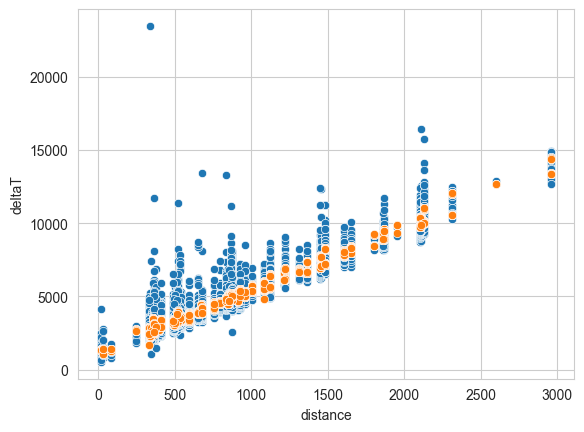

In [125]:
sns.scatterplot(y=y_test, x=X_test['distance'])
sns.scatterplot(y=y_pred, x=X_test['distance'])

In [126]:
# Calcule os erros
erros = (y_test - y_pred)/(3600)

# Crie um DataFrame com as previsões, os valores reais e os erros
df_resultados = pd.DataFrame({'Previsões': y_pred, 'Valores Reais': y_test, 'Erros': erros})

df_resultados['erro_minutos']=df_resultados['Erros']*60
# Imprima o DataFrame
df_resultados

,Previsões,Valores Reais,Erros,erro_minutos
ee773ccba164a62e997558d8ee9a2263,10355.444296,10290.0,-0.018179,-1.090738
db82a798ec8cee3f819ffe2a78461e00,3262.764128,3155.0,-0.029934,-1.796069
750cf04aafd9ecfbdb32ceb558b8b873,4896.577017,5060.0,0.045395,2.723716
65c2a6dcd18b2f4e7b977d2386cb1daa,5632.435366,5584.0,-0.013454,-0.807256
15931ed5b983d81d0cf1ac8489b0ee55,2552.643785,2352.0,-0.055734,-3.344063
...,...,...,...,...
c4de7b1ad8b932e7831ea27e95bf95b9,2462.795587,2553.0,0.025057,1.503407
0c23ec16b78457a55d0b7c15657806ad,10029.652094,9949.0,-0.022403,-1.344202
55318e658868c4fc44dac6688b3d8411,6150.540670,6607.0,0.126794,7.607656
47848407a28a412ebbf21cc9a7219dbf,2544.643785,2471.0,-0.020457,-1.227396


In [127]:
threshold = 30

mask = (df_resultados['erro_minutos']>=threshold) | (df_resultados['erro_minutos']<=-threshold)
erros_index = df_resultados[mask].index
df_resultados[mask].sort_values(by='erro_minutos')

,Previsões,Valores Reais,Erros,erro_minutos
4cf15e6b611e056799680b5c0e78ff01,5071.495583,2540.0,-0.703193,-42.191593
4039f92618b7da585758ffbaf9baa5cb,6843.892526,8648.0,0.501141,30.068458
7437783174ed59ea0803a6eb16ed2461,2554.643785,4362.0,0.502043,30.122604
3094ee2d9182ac635c6ebcf02b95595e,3095.463788,4908.0,0.503482,30.208937
b71a6f3a6b92292eb486d1d0fb1ef989,5381.529376,7196.0,0.504020,30.241177
...,...,...,...,...
e006114086c6f8c375358d19f0297e5d,3870.057184,11373.0,2.084151,125.049047
8eeff4a9e856f491967a1b5a4e1119a6,4728.639766,13260.0,2.369822,142.189337
b0d48552fe6389caa7a12ac8b7527f22,2580.643785,11688.0,2.529821,151.789270
112da3c79edb277e89b64d9baca71b97,3907.555880,13441.0,2.648179,158.890735


In [10]:
check = X_test.loc[erros_index]
# check[(check['esperchecks'] != 0) | (check['troca'] != 0)]
check.loc['92ee1e12b540f75f45c0e3e2b2526bc4']

origem                                                      SBSP
destino                                                     SBRJ
dt_dep                                       2023-01-07 14:37:29
esperas                                                        1
metaf                                                        NaN
metar          METAR SBRJ 071400Z 36004KT 5000 -RA BR SCT007 ...
troca                                                          0
distance                                              365.627841
distanceCAT                                           340.290755
temperature                                                 21.0
dew_point                                                   19.0
wind_dir                                                   360.0
pressure                                                  1018.0
clouds         [('SCT', 700.0, None), ('BKN', 1000.0, None), ...
visibility                                                5000.0
wind_speed               

# Run Oficial Model

In [6]:
data_merge

,distance,distanceCAT,mean_flight_time,deltaT,hour_rounded,temperature,pressure,visibility,v,u
0,1007.982120,910.178961,5680.203488,5547.0,1,13.0,1021.0,1,-0.026231,4.999931
1,373.769188,411.540159,2829.893874,3006.0,9,17.0,1019.0,1,1.384448,1.443365
2,866.126835,809.864437,5044.644589,5020.0,1,9.0,1021.0,1,0.293895,2.985570
3,866.126835,809.864437,5044.644589,5262.0,1,9.0,1021.0,1,0.293895,2.985570
4,874.428439,794.273105,4879.577017,5084.0,1,9.0,1021.0,1,0.001149,3.000000
...,...,...,...,...,...,...,...,...,...,...
298612,1654.523543,1488.045264,7960.373434,7564.0,12,29.0,1016.0,1,-1.975665,5.665399
298613,854.437636,816.533272,4671.939655,5126.0,10,12.0,1020.0,1,-3.949235,0.635248
298614,1608.642575,1447.775576,7768.930088,7591.0,17,29.0,1013.0,1,5.334119,5.962145
298615,1450.625163,1373.913330,7631.702415,8743.0,5,14.0,1021.0,1,2.791988,5.310820


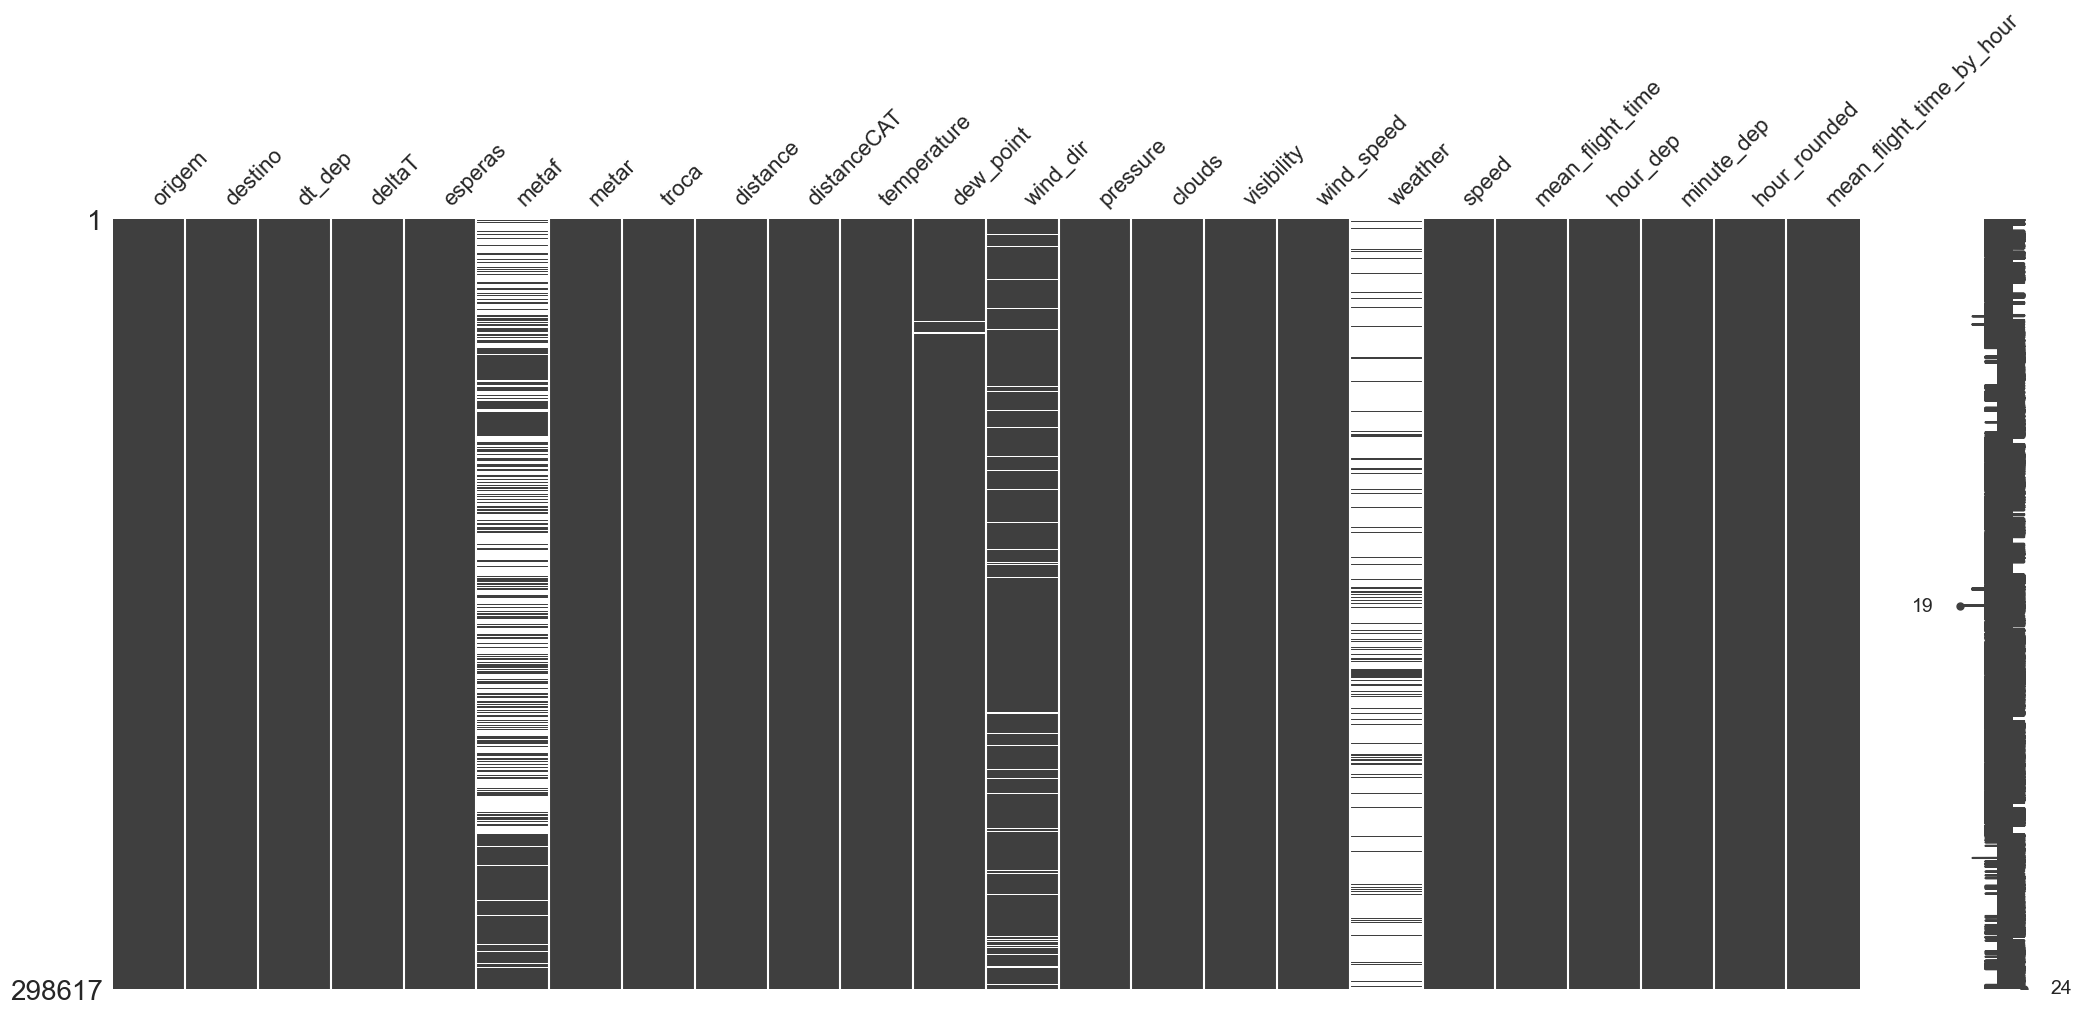

,esperas,troca,distance,v,u,temperature,weather,mean_flight_time,mean_flight_time_by_hour
59783,0,0,1654.523543,-3.951331,11.330798,27.0,1,7960.373434,7963.748656
226213,0,0,406.747989,-7.997630,0.194735,24.0,0,3291.001385,3362.157100
193151,0,0,365.627841,8.517372,5.239692,28.0,1,3053.463788,3030.902415
207957,0,0,591.874898,0.125683,1.996047,22.0,1,3298.964493,3218.334821
184932,0,0,797.929505,6.985303,0.453368,28.0,1,4497.105887,4536.610039
...,...,...,...,...,...,...,...,...,...
119879,0,1,363.090587,7.481510,6.635285,17.0,1,2732.400974,2681.394737
259178,0,0,359.678450,-2.336598,4.420442,16.0,1,2639.687286,2520.345794
131932,0,0,866.126835,0.000000,0.000000,21.0,1,5126.385609,4833.247761
146867,0,0,365.627841,11.726965,10.884774,25.0,1,2523.643785,2538.034119


In [3]:
data_merge = pd.read_csv('./data/all.csv', index_col=0)

data_merge = data_merge.merge(cont_test, on=['origem', 'destino'], how='left')

data_merge['dt_dep'] = pd.to_datetime(data_merge['dt_dep'])

data_merge['hour_dep'] = data_merge['dt_dep'].dt.hour
data_merge['minute_dep'] = data_merge['dt_dep'].dt.minute
data_merge['hour_rounded'] = round((data_merge['hour_dep']*60 + data_merge['minute_dep'])/60, 0)
data_merge['hour_rounded'] = data_merge['hour_rounded'].astype('int')
data_merge = data_merge.merge(tn_test, on=['origem', 'destino','hour_rounded'], how='left')

msno.matrix(data_merge)
plt.show()
#####################
# Função para calcular o ângulo entre os vetores
def calcular_angulo(row, aeroportos):
    aeroporto_origem = row['origem']
    aeroporto_chegada = row['destino']

    lat_lon_origem = aeroportos[aeroporto_origem]
    lat_lon_chegada = aeroportos[aeroporto_chegada]

    lat1, lon1 = lat_lon_origem
    lat2, lon2 = lat_lon_chegada

    angulo_radianos = math.atan2(lat2 - lat1, lon2 - lon1)
    angulo_graus = math.degrees(angulo_radianos) % 360

    return angulo_graus

# Supondo que você tenha um DataFrame chamado df com as colunas 'AeroportoOrigem' e 'AeroportoChegada'
# e uma coluna 'Distancia' com as distâncias entre os aeroportos

# Aplicar a função calcular_angulo a cada linha do DataFrame
data_merge['Angulo'] = data_merge.apply(calcular_angulo, args=(AEROPORTOS,), axis=1)

data_merge['relative_dir'] =  180 - abs( 180 - abs(data_merge['Angulo']- data_merge['wind_dir']))

data_merge['v'] = data_merge['wind_speed'] * np.cos(data_merge['relative_dir']*np.pi/180)
data_merge['u'] = data_merge['wind_speed'] * np.sin(data_merge['relative_dir']*np.pi/180)
####################

def categorizar(valor):
    if valor > 5000:
        return 1  # nice visibility
    else:
        return 0
    
data_merge['visibility'] = data_merge['visibility'].map(categorizar)

def replace_value(value):
    if value is np.nan:
        return 1  # nice weather
    else:
        return 0

def len_clouds(value):
    return value.count(")")

data_merge['clouds'] = data_merge['clouds'].apply(len_clouds)

data_merge['weather'] = data_merge['weather'].apply(replace_value)
data_merge['weather_overall'] = data_merge['weather'] & data_merge['visibility']

##### Possible columns:
# 'origem', 'destino', 'dt_dep', 'esperas', 'metaf', 'metar', 'troca',
# 'distance', 'distanceCAT', 'temperature', 'dew_point', 'wind_dir',
# 'pressure', 'clouds', 'visibility', 'wind_speed', 'weather', 'mean_flight_time','deltaT','v','u'

cols = ['deltaT', 'esperas', 'troca', 'distance','v','u','temperature', 'weather', 'mean_flight_time', 'mean_flight_time_by_hour']

data_merge = data_merge[cols]

data_merge = data_merge.fillna(method='ffill')

X =  data_merge.drop(['deltaT'], axis=1)
y =  data_merge['deltaT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train

In [4]:
# from sklearn.ensemble import GradientBoostingRegressor

# Crie um regressor Random Forest
# rf_regressor = RandomForestRegressor(**grid_search.best_params_, random_state=42)
rf_regressor = RandomForestRegressor(n_estimators=120,max_depth=15, max_features =0.75, min_samples_leaf=3, random_state=42)

# rf_regressor = GradientBoostingRegressor(learning_rate=0.1, n_estimators=50,
#     max_depth=12, random_state=42, alpha=0.9
# )

# Treine o modelo no conjunto de treinamento
rf_regressor.fit(X_train, y_train)

# Faça previsões no conjunto de teste
y_pred = rf_regressor.predict(X_test)
y_pred_train = rf_regressor.predict(X_train)

# Avalie o desempenho do modelo
mse = mean_squared_error(y_test, y_pred)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mse)

# Imprima as métricas de desempenho
print(f"Erro Quadrático Médio (MSE): {mse}")
print(f"Erro Quadrático Médio Train Set (MSE): {mse_train}")
print(f"RMSE: {rmse}")

Erro Quadrático Médio (MSE): 143897.92018722068
Erro Quadrático Médio Train Set (MSE): 102830.44641250238
RMSE: 379.33879341193233


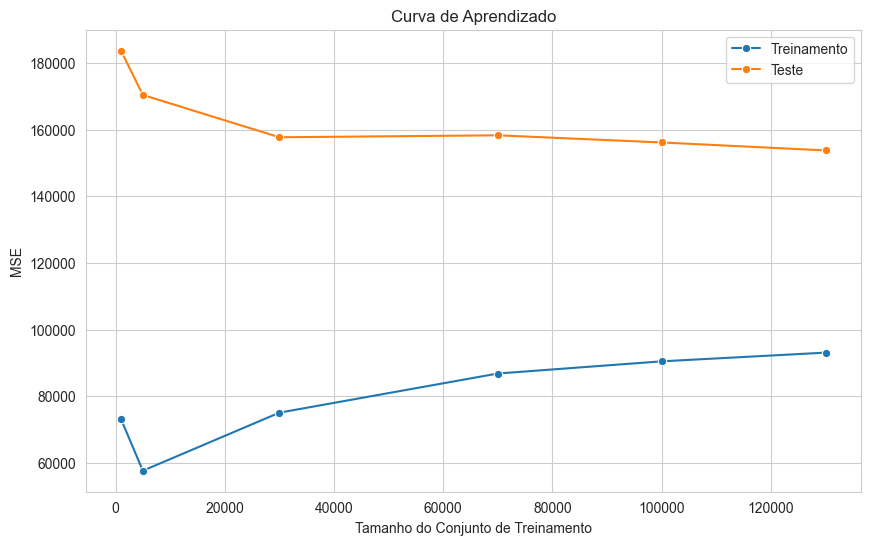

In [31]:
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold

# Plote a curva de aprendizado
train_sizes, train_scores, test_scores = learning_curve(rf_regressor, X, y, cv=KFold(n_splits=2), scoring='neg_mean_squared_error', train_sizes=[1000,5000, 30000, 70000,100000, 130000])
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Curva de Aprendizado")
plt.xlabel("Tamanho do Conjunto de Treinamento")
plt.ylabel("MSE")

sns.lineplot(x=train_sizes, y=train_scores_mean, ls='-', marker='o', label="Treinamento")
sns.lineplot(x=train_sizes, y=test_scores_mean, ls='-', marker='o', label="Teste")
plt.legend(loc="best")
plt.show()

In [18]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error

# Create a random forest model
rf = RandomForestRegressor(random_state=42)

# # Define the hyperparameter grid to search
param_grid = {
    'max_depth': [20], # Default = None
    'min_samples_leaf': [3], # Default = 1
    # 'min_samples_split': [2, 3, 4], # Default = 2
    'n_estimators': [120], # Default = 100
    # 'bootstrap':[True, False], # Default = True
    'max_features': [0.75] # Default = 1.0
}


# Instantiate the grid search model
grid_search = GridSearchCV(
                                estimator = rf, 
                                param_grid = param_grid, 
                                n_jobs = -1, 
                                verbose = 2, 
                                return_train_score=True, 
                                cv = KFold(n_splits=3),
                                scoring=make_scorer(score_func=mean_squared_error, greater_is_better=False)
                            )

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding RMSE score
print("Best Hyperparameters: ", grid_search.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Hyperparameters:  {'max_depth': 20, 'max_features': 0.75, 'min_samples_leaf': 3, 'n_estimators': 120}


In [79]:
print("Best Score: ", grid_search.best_score_)

Best Score:  -134673.79763692385


<Axes: xlabel='mean_flight_time', ylabel='deltaT'>

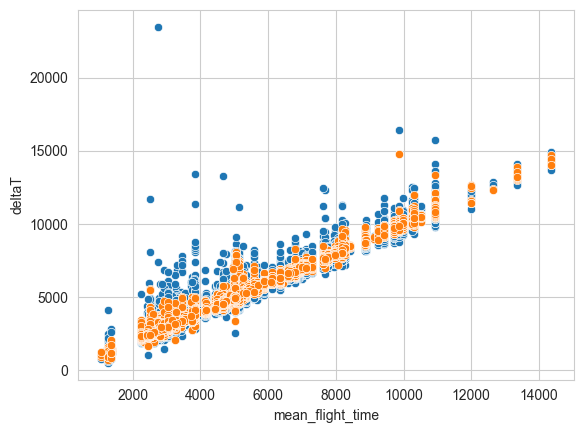

In [21]:
sns.scatterplot(y=y_test, x=X_test['mean_flight_time'])
sns.scatterplot(y=y_pred, x=X_test['mean_flight_time'])

In [9]:
# Calcule os erros
erros = (y_test - y_pred)/(3600)

# Crie um DataFrame com as previsões, os valores reais e os erros
df_resultados = pd.DataFrame({'Previsões': y_pred, 'Valores Reais': y_test, 'Erros': erros})

df_resultados['erro_minutos']=df_resultados['Erros']*60
# Imprima o DataFrame
df_resultados

,Previsões,Valores Reais,Erros,erro_minutos
105934,10294.810207,10290.0,-0.001336,-0.080170
42794,3136.830106,3155.0,0.005047,0.302832
39852,4790.836526,5060.0,0.074768,4.486058
97137,5456.905908,5584.0,0.035304,2.118235
240961,2467.744697,2352.0,-0.032151,-1.929078
...,...,...,...,...
49351,2413.278332,2553.0,0.038812,2.328694
231240,9996.778392,9949.0,-0.013272,-0.796307
155300,6087.335473,6607.0,0.144351,8.661075
34011,2485.245946,2471.0,-0.003957,-0.237432


In [10]:
threshold = 30

mask = (df_resultados['erro_minutos']>=threshold) | (df_resultados['erro_minutos']<=-threshold)
erros_index = df_resultados[mask].index
df_resultados[mask].sort_values(by='erro_minutos')

,Previsões,Valores Reais,Erros,erro_minutos
156400,8617.212303,2331.0,-1.746170,-104.770205
12294,7333.421335,4864.0,-0.685950,-41.157022
259271,12339.398889,9892.0,-0.679833,-40.789981
104042,12270.187504,9894.0,-0.660052,-39.603125
120607,9980.319081,7763.0,-0.615922,-36.955318
...,...,...,...,...
73085,3925.741674,11373.0,2.068683,124.120972
274614,5484.134528,13260.0,2.159963,129.597758
122333,4625.205251,13441.0,2.448832,146.929912
122334,2559.802090,11688.0,2.535611,152.136632


In [101]:
check = X_test.loc[erros_index]
check

,distance,mean_flight_time,hour_rounded,temperature,dew_point,pressure,clouds,visibility,v,weather,u
122333,675.423676,3845.555880,10,18.0,16.0,1021.0,3,1,4.156642,0,5.632257
147655,1479.504420,8195.000699,16,27.0,18.0,1015.0,2,1,0.337900,0,8.993655
177636,675.423676,3845.555880,15,21.0,19.0,1018.0,3,0,2.173511,0,2.067813
145023,1479.504420,8195.000699,7,19.0,17.0,1006.0,1,1,-2.971899,1,0.409655
214423,837.607091,4680.639766,16,24.0,19.0,1018.0,3,1,2.782696,0,10.642209
...,...,...,...,...,...,...,...,...,...,...,...
11522,515.566803,3746.491044,10,8.0,8.0,1022.0,1,0,1.988443,0,0.214697
276365,488.073154,3237.764128,22,21.0,20.0,1006.0,3,1,-2.103407,0,4.536042
222061,336.456265,2761.744132,16,28.0,20.0,1021.0,2,1,1.890708,1,0.652092
42909,866.126835,5044.644589,19,23.0,18.0,1018.0,0,1,4.064386,1,2.912175


<Axes: title={'center': 'Feature Importance de um Random Forest'}, xlabel='Importância das Características'>

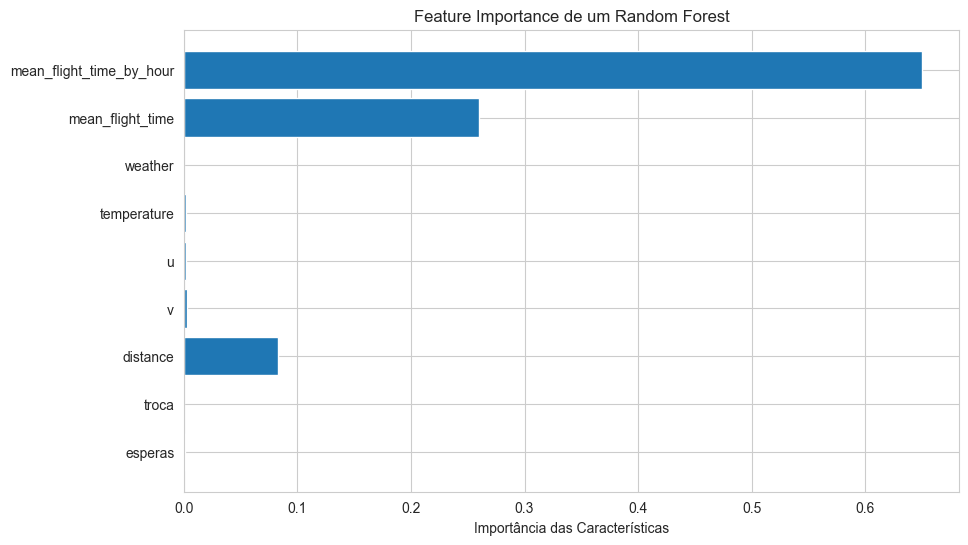

In [32]:
# Obtenha as importâncias das características do rf_regressoro
feature_importances = rf_regressor.feature_importances_
feature_names = X_train.columns

# Crie um gráfico de barras bonito para mostrar a importância das características
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align='center')
plt.yticks(np.arange(len(feature_importances)), feature_names)
plt.xlabel('Importância das Características')
plt.title('Feature Importance de um Random Forest')
plt.gca()

# Calculate for submission data

In [14]:
data_test = pd.read_csv('data/idsc_dataset.csv', sep=';')

data_test['metar'].fillna(method='ffill', inplace=True)
data_test['metar'] = data_test['metar'].apply(lambda x: x[:11]+'30'+x[13:] if x[11:13]=='31' else x)

In [15]:
trajetorias = pd.read_csv('trajetorias.csv')

data_test = data_test.merge(cont_test, on=['origem', 'destino'], how='left')


data_test = data_test.merge(trajetorias, on=['origem','destino'],how='left')

data_test['distance'] = data_test.apply(calcular_distancia, axis=1)

data_test['distanceCAT'].fillna(data_test['distance'], inplace=True)

# data_test[['distance', 'distanceCAT']] = scaler.transform(data_test[['distance', 'distanceCAT']])

data_test.head(5)

,flightid,origem,destino,hora_ref,dt_dep,snapshot_radar,path,hora_esperas,esperas,aero_esperas,...,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr,mean_flight_time,distanceCAT,distance
0,4f0356600f61e3fcbea8ed8a137a2423,SBBR,SBSP,11:00:00,11:53:30,MULTIPOINT ((-0.9862962481402141 -0.2329259019...,http://satelite.cptec.inpe.br/repositoriogoes/...,10:00:00,1,SBSP,...,METAR SBSP 211000Z 34007KT 290V010 CAVOK 18/13...,SBSP,11:00:00,0.0,SBSP,NaN,NaN,5031.495583,839.818058,872.709147
1,865dbbbe74bebea18a71f24342516ff0,SBSP,SBCT,00:00:00,00:04:37,MULTIPOINT ((-0.8863534722346053 -0.5093356150...,http://satelite.cptec.inpe.br/repositoriogoes/...,23:00:00,0,SBCT,...,METAR SBCT 142300Z 13005KT 100V200 CAVOK 11/06...,SBCT,00:00:00,0.0,SBCT,23:00:00,SBCT,2432.795587,328.361444,331.045035
2,1803af9cfc6a2c74d188481e3ffd848e,SBGR,SBPA,01:00:00,01:33:15,MULTIPOINT ((-0.8966138193125871 -0.5115119601...,http://satelite.cptec.inpe.br/repositoriogoes/...,00:00:00,0,SBPA,...,METAR SBPA 030000Z 07004KT 030V090 9000 NSC 21...,SBPA,01:00:00,0.0,SBPA,NaN,NaN,5044.644589,809.864437,866.126835
3,f6af733a687f904183efd149ec713be5,SBCT,SBSV,03:00:00,03:54:14,MULTIPOINT ((-0.8586718860112791 -0.4418648049...,http://satelite.cptec.inpe.br/repositoriogoes/...,02:00:00,0,SBSV,...,METAR SBSV 150200Z 06009KT 9999 SCT020 25/22 Q...,SBSV,03:00:00,0.0,SBSV,02:00:00,SBSV,8424.911765,1804.723136,1804.723136
4,6117f9ac60b7f66b740c9130be433313,SBRJ,SBGR,00:00:00,00:27:32,MULTIPOINT ((-0.8914635585346382 -0.5234904405...,http://satelite.cptec.inpe.br/repositoriogoes/...,23:00:00,0,SBGR,...,METAR COR SBGR 222300Z 06004KT CAVOK 23/08 Q1013=,SBGR,00:00:00,0.0,SBGR,23:00:00,SBGR,2763.213679,381.291330,342.948013


C:\Users\Lucas Ramos\AppData\Local\Temp\ipykernel_15000\3440125237.py:77: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_test['dt_dep'] = pd.to_datetime(data_test['dt_dep'])


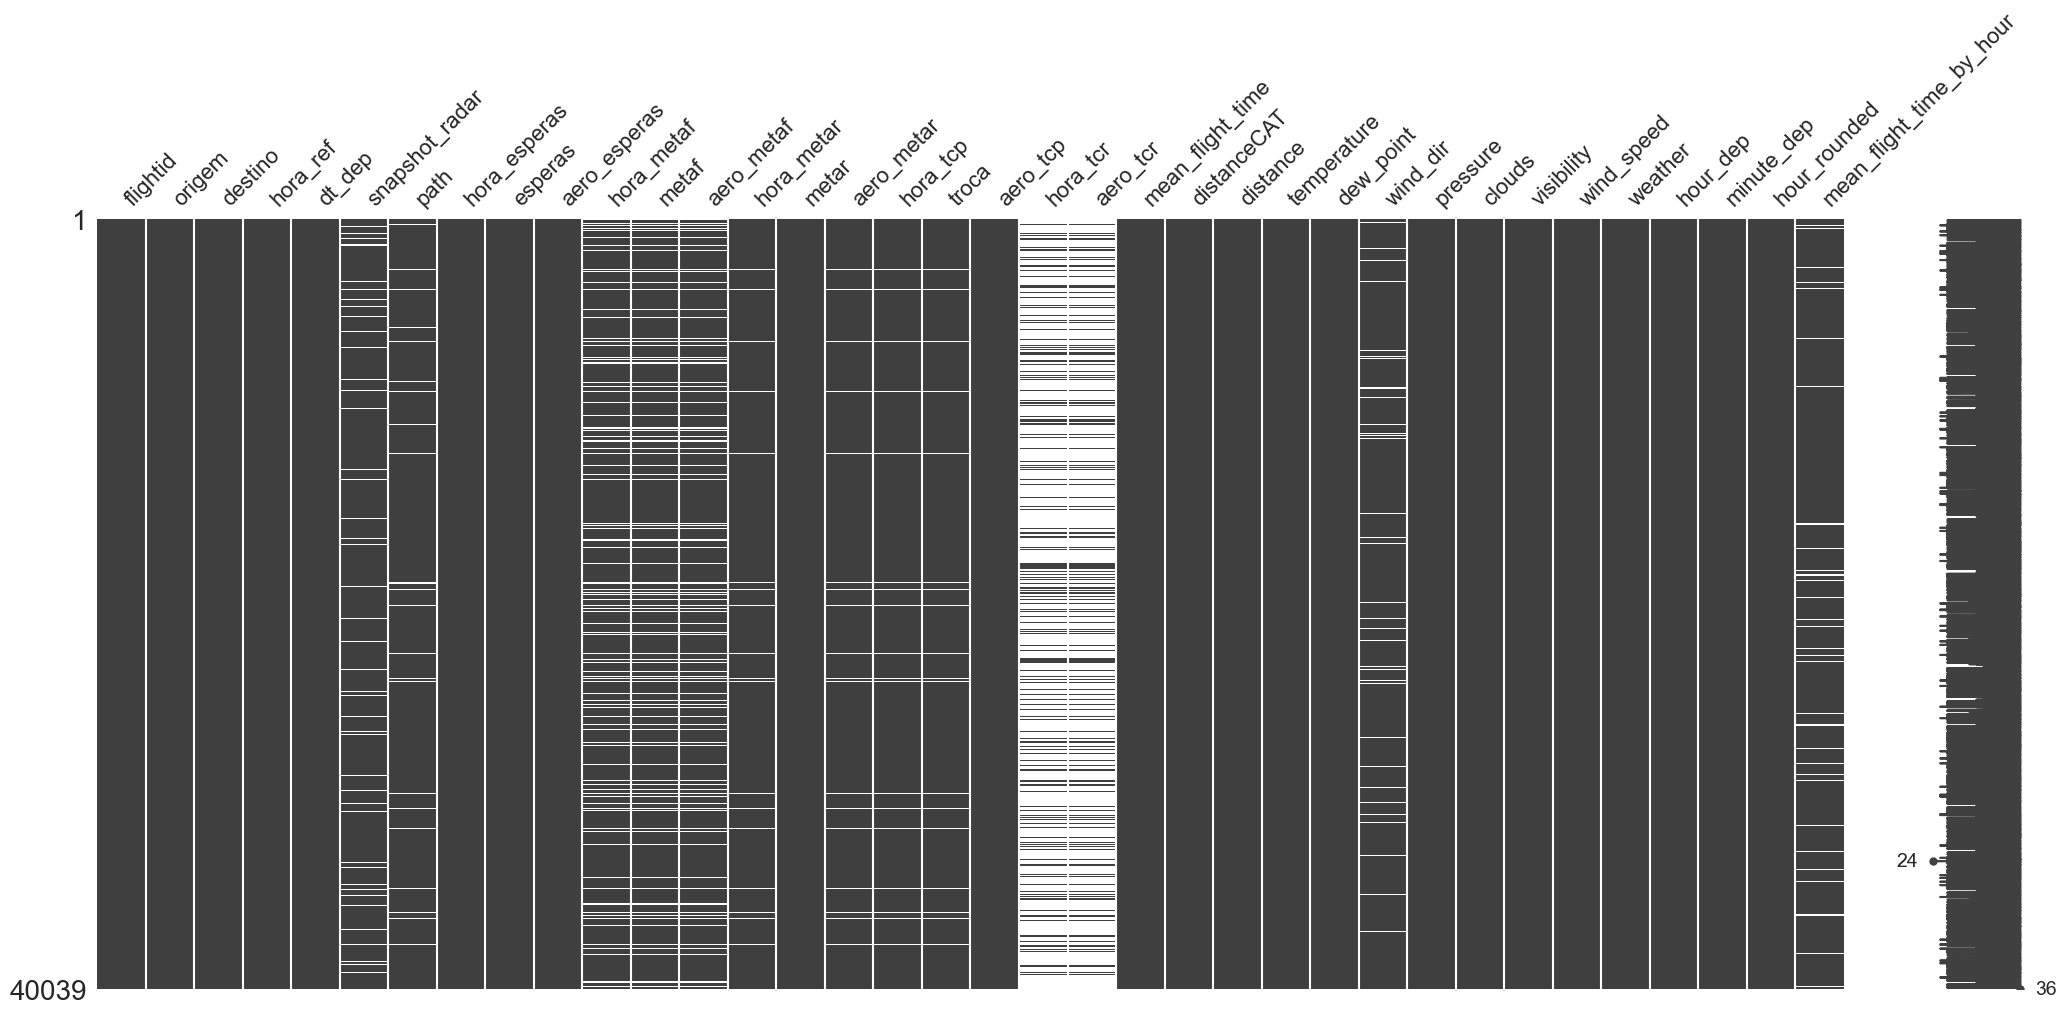

,flightid,origem,destino,hora_ref,dt_dep,snapshot_radar,path,hora_esperas,esperas,aero_esperas,...,wind_speed,weather,hour_dep,minute_dep,hour_rounded,mean_flight_time_by_hour,Angulo,relative_dir,v,u
0,4f0356600f61e3fcbea8ed8a137a2423,SBBR,SBSP,11:00:00,2023-10-07 11:53:30,MULTIPOINT ((-0.9862962481402141 -0.2329259019...,http://satelite.cptec.inpe.br/repositoriogoes/...,10:00:00,1,SBSP,...,7.0,1,11,53,12,5059.753747,279.256804,60.743196,3.421074,6.107066
1,865dbbbe74bebea18a71f24342516ff0,SBSP,SBCT,00:00:00,2023-10-07 00:04:37,MULTIPOINT ((-0.8863534722346053 -0.5093356150...,http://satelite.cptec.inpe.br/repositoriogoes/...,23:00:00,0,SBCT,...,5.0,1,0,4,0,2459.725389,217.130242,87.130242,0.250329,4.993730
2,1803af9cfc6a2c74d188481e3ffd848e,SBGR,SBPA,01:00:00,2023-10-07 01:33:15,MULTIPOINT ((-0.8966138193125871 -0.5115119601...,http://satelite.cptec.inpe.br/repositoriogoes/...,00:00:00,0,SBPA,...,4.0,1,1,33,2,4931.389041,234.378006,164.378006,-3.852237,1.077158
3,f6af733a687f904183efd149ec713be5,SBCT,SBSV,03:00:00,2023-10-07 03:54:14,MULTIPOINT ((-0.8586718860112791 -0.4418648049...,http://satelite.cptec.inpe.br/repositoriogoes/...,02:00:00,0,SBSV,...,9.0,1,3,54,4,8249.333333,49.333521,10.666479,8.844491,1.665825
4,6117f9ac60b7f66b740c9130be433313,SBRJ,SBGR,00:00:00,2023-10-07 00:27:32,MULTIPOINT ((-0.8914635585346382 -0.5234904405...,http://satelite.cptec.inpe.br/repositoriogoes/...,23:00:00,0,SBGR,...,4.0,1,0,27,0,2829.436893,188.953851,128.953851,-2.514777,3.110610


In [17]:
from metar import Metar
import numpy as np

def wind_speed(metar):
    try:
        return Metar.Metar(metar).wind_speed._value 
    except:
        return np.nan
    
def vis_distance(metar):
    try:
        return Metar.Metar(metar).vis._value
    except:
        return np.nan
    
def temperature(metar):
    try:
        return Metar.Metar(metar).temp._value
    except:
        return np.nan
    
def dew_point(metar):
    try:
        return Metar.Metar(metar).dewpt._value
    except:
        return np.nan
    
def wind_dir(metar):
    try:
        return Metar.Metar(metar).wind_dir._degrees
    except:
        return np.nan

def pressure(metar):
    try:
        return Metar.Metar(metar).press._value
    except:
        return np.nan
    
def clouds(metar):
    try:
        return Metar.Metar(metar).sky
    except:
        return np.nan

data_test['temperature'] = data_test.apply(lambda row: temperature(row['metar']), axis=1)
data_test['dew_point'] = data_test.apply(lambda row: dew_point(row['metar']), axis=1)
data_test['wind_dir'] = data_test.apply(lambda row: wind_dir(row['metar']), axis=1)
data_test['pressure'] = data_test.apply(lambda row: pressure(row['metar']), axis=1)
data_test['clouds'] = data_test.apply(lambda row: clouds(row['metar']), axis=1)

data_test['visibility'] = data_test.apply(lambda row: vis_distance(row['metar']), axis=1)
data_test['wind_speed'] = data_test.apply(lambda row: wind_speed(row['metar']), axis=1)
data_test['weather'] = data_test.apply(lambda row: Metar.Metar(row['metar']).present_weather(), axis=1)

def categorizar(valor):
    if valor > 5000:
        return 1
    else:
        return 0
    
data_test['visibility'] = data_test['visibility'].map(categorizar)

def replace_value(value):
    if value is np.nan:
        return 0
    else:
        return 1

data_test['weather'] = data_test['weather'].apply(replace_value)

def len_clouds(value):
    return value.count(")")

data_test['clouds'] = data_test['clouds'].apply(len_clouds)

data_test['dt_dep'] = pd.to_datetime(data_test['dt_dep'])

data_test['hour_dep'] = data_test['dt_dep'].dt.hour
data_test['minute_dep'] = data_test['dt_dep'].dt.minute
data_test['hour_rounded'] = round((data_test['hour_dep']*60 + data_test['minute_dep'])/60, 0)
data_test['hour_rounded'] = data_test['hour_rounded'].astype('int')

data_test = data_test.merge(tn_test, on=['origem', 'destino','hour_rounded'], how='left')
msno.matrix(data_test)
plt.show()
# Aplicar a função calcular_angulo a cada linha do DataFrame
data_test['Angulo'] = data_test.apply(calcular_angulo, args=(AEROPORTOS,), axis=1)

data_test['relative_dir'] =  180 - abs( 180 - abs(data_test['Angulo']- data_test['wind_dir']))

data_test['v'] = data_test['wind_speed'] * np.cos(data_test['relative_dir']*np.pi/180)
data_test['u'] = data_test['wind_speed'] * np.sin(data_test['relative_dir']*np.pi/180)

data_test = data_test.fillna(method='ffill')

data_test.head(5)

In [11]:
# cols = ['distanceCAT', 'hour_rounded']
cols.remove('deltaT')
X_submission =  data_test[cols]

y_pred = rf_regressor.predict(X_submission)

y_pred

array([5070.52576113, 2512.19362963, 4879.68311686, ..., 2928.8915377 ,
       4652.86900283, 5060.05121296])

In [12]:
data_submission = data_test[['flightid']].copy()
data_submission['solution'] = y_pred

data_submission = data_submission.rename(columns={'flightid':'ID'})

#data_submission['solution'] = data_submission['solution'].astype('int')
data_submission

,ID,solution
0,4f0356600f61e3fcbea8ed8a137a2423,5070.525761
1,865dbbbe74bebea18a71f24342516ff0,2512.193630
2,1803af9cfc6a2c74d188481e3ffd848e,4879.683117
3,f6af733a687f904183efd149ec713be5,8239.354784
4,6117f9ac60b7f66b740c9130be433313,2786.186297
...,...,...
40034,4e08052066073297c7a3c55798618324,3883.333575
40035,e22f120c65f5759aa8df576b59d71be3,2619.259061
40036,ca9399162037201a4d0c49c832a32739,2928.891538
40037,560136088f5f1493dbad809a3554172c,4652.869003


In [13]:
data_submission.to_csv('submission/mean_flight_by_hour_120_15_075_3.csv',index=False)